In [1]:
import xarray as xr
import sys
import matplotlib.pyplot as plt
import os
import tqdm
from tqdm import tqdm
import tqdm
import tensorflow as tf
import numpy as np
import cartopy.crs as ccrs
import matplotlib.colors as mcolors
#DisableqdGPU
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"
from comet_ml import Experiment
import numpy as np
import tensorflow as tf
import albumentations as A
from functools import partial
AUTOTUNE = tf.data.experimental.AUTOTUNE
from dask.diagnostics import ProgressBar

import pandas as pd
# Create an experiment with your api key
sys.path.append(r'/nesi/project/niwa00018/ML_downscaling_CCAM/training_GAN')
from src_unet_init_step import *
from paper_experiments.analyse_experiments_src import *
from tensorflow.keras import layers
import pandas as pd
import json
# changed activation function to hyperbolic tangent

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


### Things to do:

1. Create a dataset for casacade gan for noresm2-mm and acess-cm2
2. do the same for the base model and unet (both GCMs not used in trained)
3. create the required figures. 
4. use perfect fields from access-cm2 and ec-earth3, to highlight the importance of the perfect vs imperfect framework. 
5. standard deviation in rainfall on extreme events or something?

In [2]:
import tensorflow as tf
model_dir ='/nesi/project/niwa00018/ML_downscaling_CCAM/training_GAN/paper_experiments/models/'
filepath = '/nesi/project/niwa00018/ML_downscaling_CCAM/training_GAN/ancil_fields/ERA5_eval_ccam_12km.198110_NZ_Invariant.nc'
model = 'EC-Earth3'
means_filepath = "/nesi/project/niwa00018/ML_downscaling_CCAM/Training_CNN/inputs/ERA5/mean_1974_2011.nc"
stds_filepath = "/nesi/project/niwa00018/ML_downscaling_CCAM/Training_CNN/inputs/ERA5/std_1974_2011.nc"
variables = ['q_500', 'q_850', 'u_500', 'u_850', 'v_500', 'v_850', 't_500', 't_850']
framework ='perfect'
experiment = 'Intensity_Penalty'


# Loading the X, y data for plotting

In [3]:

dsets = xr.open_dataset(f'/nesi/project/niwa00018/ML_downscaling_CCAM/training_GAN/paper_experiments/outputs/{experiment}/{model}_{experiment}_hist_1986_2005_cascaded_{framework}_applied.nc')
with ProgressBar():
    dsets = dsets.load()

In [5]:
boundaries2 = [0, 5,12.5, 15, 20, 25,30, 35, 40, 50, 60, 70, 80, 100, 125, 150, 200, 250]
colors2 = [[0.000, 0.000, 0.000, 0.000], [0.875, 0.875, 0.875, 0.784],\
          [0.761, 0.761, 0.761, 1.000], [0.639, 0.886, 0.871, 1.000], [0.388, 0.773, 0.616, 1.000],\
          [0.000, 0.392, 0.392, 0.588], [0.000, 0.576, 0.576, 0.667], [0.000, 0.792, 0.792, 0.745],\
          [0.000, 0.855, 0.855, 0.863], [0.212, 1.000, 1.000, 1.000], [0.953, 0.855, 0.992, 1.000],\
          [0.918, 0.765, 0.992, 1.000], [0.918, 0.612, 1.000, 1.000], [0.878, 0.431, 1.000, 1.000],\
          [0.886, 0.349, 1.000, 1.000], [0.651, 0.004, 0.788, 1.000], [0.357, 0.008, 0.431, 1.000],\
          [0.180, 0.000, 0.224, 1.000]]
#reviated for clarity

# Create the colormap using ListedColormap
cmap = mcolors.ListedColormap(colors2)
norm = mcolors.BoundaryNorm(boundaries2, cmap.N)

In [31]:
pressure_fields = xr.open_dataset(r'//nesi/project/niwa00018/ML_downscaling_CCAM/multi-variate-gan/inputs/target_fields/ACCESS-CM2_hist_ssp370_pr_psl_tasmin_tasmax_sfcwind_sfcwindmax.nc')
pressure_fields['time'] = pd.to_datetime(pressure_fields.time.dt.strftime('%Y-%m-%d'))

In [273]:
rplling_pr = pressure_fields.pr.rolling(time = 90, center = False).mean()

In [274]:
monthly_av = pressure_fields.pr.resample(time ='1MS').mean().rolling(time =3, center =False).mean()

In [279]:
quantiles_monthly = monthly_av.sel(time = slice("1960","2014")).groupby('time.month').quantile(q =0.15, dim ="time", skipna =True)

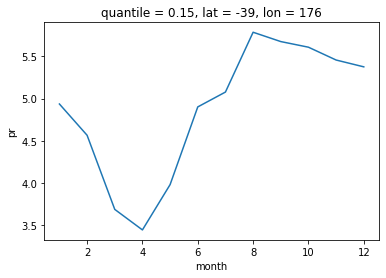

In [281]:
(quantiles_monthly.interp(lat =-39, lon =176) *3600*24).plot()

In [282]:
quantiles = rplling_pr.sel(time = slice("1960","2014")).groupby('time.dayofyear').quantile(q =0.15, dim ="time", skipna=True)

In [285]:
z = rplling_pr.interp(lat =-39, lon =176).groupby('time.dayofyear') - quantiles.interp(lat =-39, lon =176)

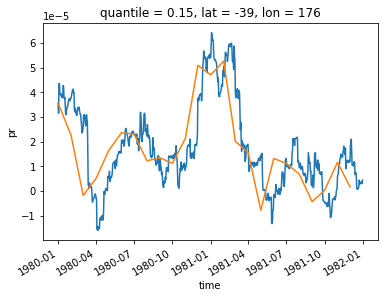

In [290]:
z.sel(time = slice("1980","1981")).plot()
anomalies.interp(lat =-39, lon =176).sel(time = slice("1980","1981")).plot()

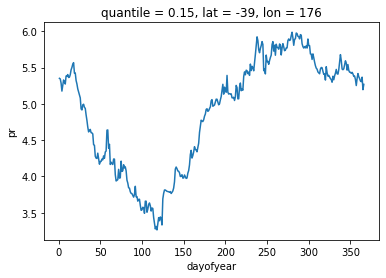

In [283]:
(quantiles.interp(lat =-39, lon =176) *3600*24).plot()

In [398]:
def f(x,a,b, c, d,e, f):
    return a* np.cos(2* x/365+d) + c * np.cos(1* x/365+b)  + e * np.cos(4* x/365+f)

In [355]:
from scipy.optimize import curve_fit

In [305]:
curve_fit

<function scipy.optimize._minpack_py.curve_fit(f, xdata, ydata, p0=None, sigma=None, absolute_sigma=False, check_finite=True, bounds=(-inf, inf), method=None, jac=None, **kwargs)>

In [399]:
x, y = curve_fit(f, quantiles.dayofyear.values, quantiles.interp(lat =-39, lon =176) *86400 )

In [413]:
def curve_function(y):
    #print(y)
    try:
        x, y = curve_fit(f, quantiles.dayofyear.values, y *86400 )
        return f(quantiles.dayofyear.values, *x)
    except:
        return y

In [ ]:
with ProgressBar():

In [1]:
# climo = xr.apply_ufunc(curve_function, quantiles, input_core_dims =[["dayofyear"]], output_core_dims=[["dayofyear"]], 
#                dask ='parallelized', output_dtypes=[float], vectorize =True)

In [400]:
seasonal = f(quantiles.dayofyear.values, *x)

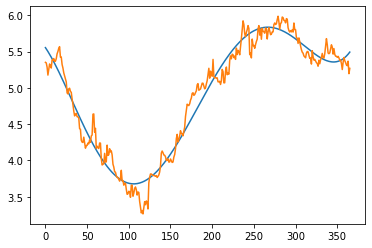

In [401]:
plt.plot(seasonal)
plt.plot(quantiles.interp(lat =-39, lon =176).values *86400)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate random frequencies

def create_xy(random_x):
    np.random.seed(np.int(random_x*1000))  # Set seed for reproducibility
    num_frequencies = 5 # Number of random frequencies
    min_freq = 0.2  # Minimum frequency
    max_freq = 1.5 # Maximum frequency
    frequencies = np.random.uniform(min_freq, max_freq, num_frequencies)
    # Generate smooth curve with random frequenciessds
    x = np.linspace(0, random_x, 1000)
    y = x.copy()  # Start with a linear trend
    for freq in frequencies:
        phase = np.random.uniform(0, np.pi *2)
        decay = np.random.uniform(0.0, 0.125)
        decay2 = np.random.uniform(0.0, 0.125)
        y += np.exp(-x*decay)*abs(np.tanh(2 * np.pi * freq * x/2+phase)) + np.exp(-x*decay)*np.sin(2 * np.pi * freq * x+phase)+ np.exp(-x*decay2)*np.cos(2 * np.pi * freq * x+phase)#**(1/2)
    return x[55:-55], np.convolve(y, np.ones(75)/75, mode ='same')[55:-55]

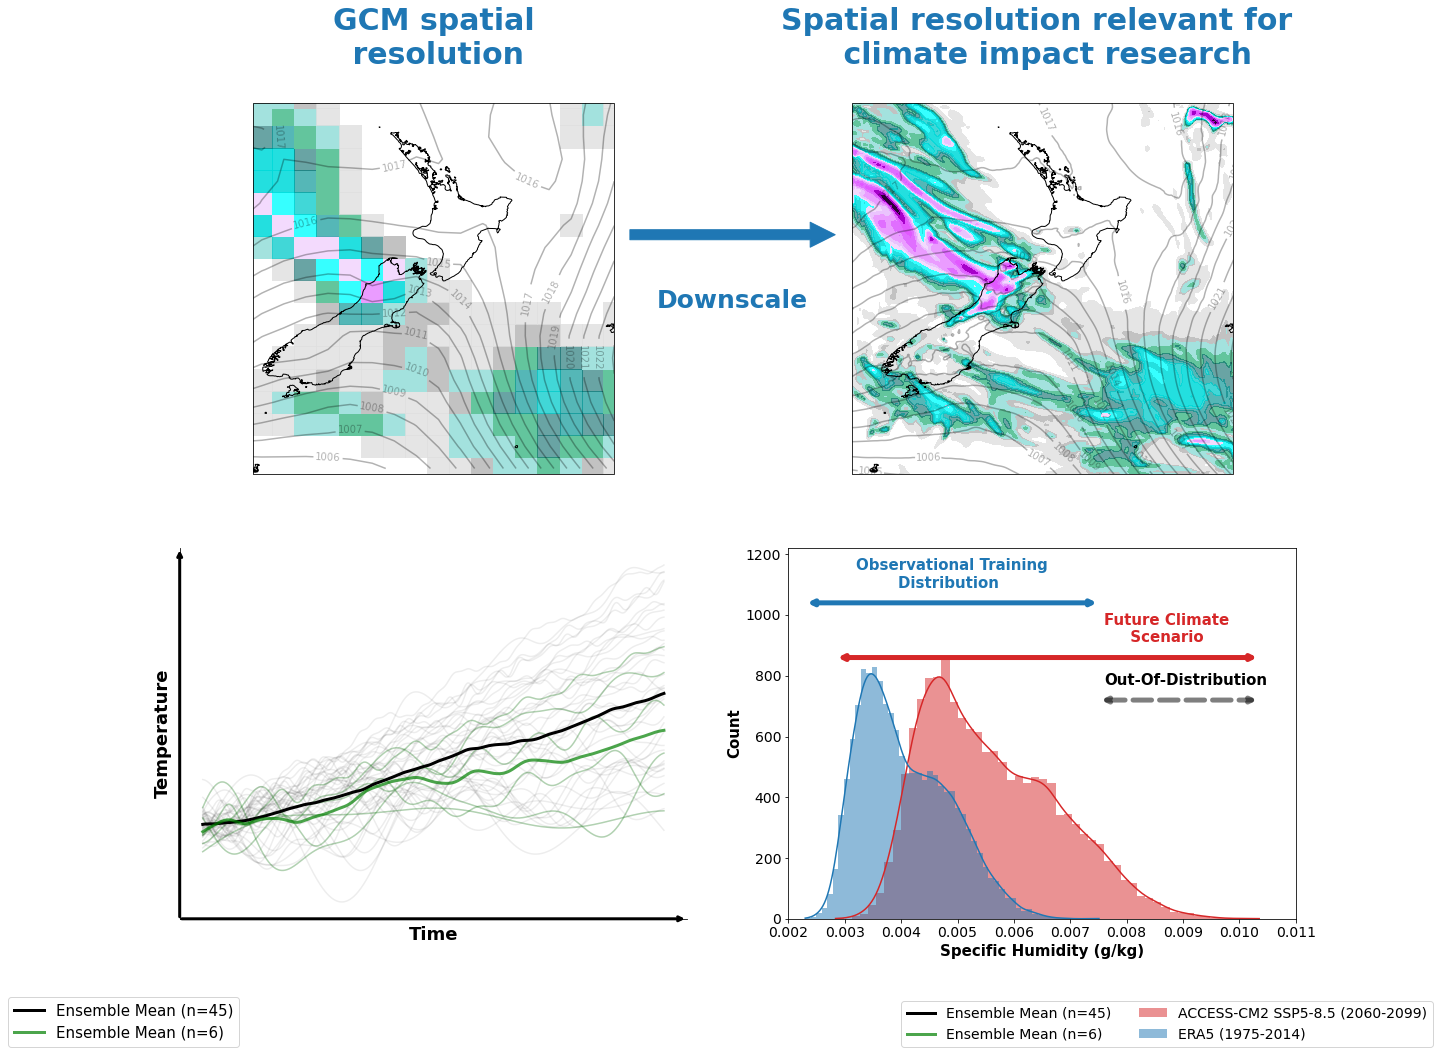

In [271]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches 
import cartopy.crs as ccrs  # Assuming you have Cartopy installed

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cartopy.crs as ccrs  # Assuming you have Cartopy installed
import matplotlib.gridspec as gs

# ------------------ Plot 1: The Cartopy Map Plot ------------------

fig = plt.figure(figsize=(20, 15))  # Adjust figure size as needed

# Create gridspec layout
grid = gs.GridSpec(2, 2, width_ratios=[4, 4], height_ratios=[12, 12])  # Adjust width/height ratios

# --- Plot 1 (gs[0,0:2]): Coarse GCM Precipitation (spans top row) ---
ax0 = fig.add_subplot(grid[0, 0], projection=ccrs.PlateCarree(central_longitude=171.77))
ax1 = fig.add_subplot(grid[0, 1], projection=ccrs.PlateCarree(central_longitude=171.77))
# Figure and subplot setup
# fig, ax = plt.subplots(1, 2, figsize=(18, 7), 
#                        subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=171.77)))

# --- Plot 1: Coarse GCM Precipitation ---
dsets.sel(time="2004-01-16").isel(member=0, experiment=0).pr.coarsen(lat=10, lon=10, boundary='pad').mean().plot(
    cmap=cmap, norm=norm,  # Assuming you've defined cmap and norm elsewhere
    ax=ax0, transform=ccrs.PlateCarree(), extend='max', add_colorbar=False
)
ax0.coastlines('10m')  # Add coastlines with 10m resolution

# --- Plot 2: GCM Precipitation Contours ---
dsets.sel(time="2004-01-16").isel(member=0, experiment=-1).pr.plot.contourf(
   cmap=cmap, norm=norm, ax=ax1, transform=ccrs.PlateCarree(), extend='max', add_colorbar=False
)
ax1.coastlines('10m')

# --- Overlaying Pressure Contours (both plots) ---
pressure_field_hpa = pressure_fields.sel(time="2004-01-16").psl / 100  # Convert from Pa to hPa
contour_plot = pressure_field_hpa.coarsen(lat=10, lon=10, boundary='pad').mean().plot.contour(
    colors='k', levels=range(980, 1030, 1), ax=ax0, transform=ccrs.PlateCarree(), alpha=0.3, zorder=15
)
contour_labels = plt.clabel(contour_plot, inline=True, fontsize=10, fmt='%1.0f')  # Add contour labels

# Duplicate for plot 2 (this could be made more efficient)
contour_plot = pressure_field_hpa.plot.contour(
    colors='k', levels=range(980, 1030, 1), ax=ax1, transform=ccrs.PlateCarree(), alpha=0.3, zorder=15
)
contour_labels = plt.clabel(contour_plot, inline=True, fontsize=10, fmt='%1.0f')

# Titles and Map Extents
ax0.set_title('GCM spatial\n resolution\n', fontsize=30, weight='bold', color='tab:blue')
ax1.set_title('Spatial resolution relevant for \n climate impact research\n', fontsize=30, weight='bold', color='tab:blue')
ax0.set_extent([166, 183.5, -51, -33], crs=ccrs.PlateCarree())
ax1.set_extent([165, 183.5, -51, -33], crs=ccrs.PlateCarree())

x_tail = ax0.get_position().x1 +0.01  # End of subplot 1
x_head = ax1.get_position().x0 -0.01 # Start of subplot 2
y_middle = (ax0.get_position().y0 + ax1.get_position().y1) / 2+0.05  # Vertical center

arrow = mpatches.FancyArrowPatch((x_tail, y_middle), (x_head, y_middle),
                                 mutation_scale=50,  # Adjust arrow size
                                 color='tab:blue')
fig.add_artist(arrow)

fig.text((x_tail + x_head) / 2, y_middle-0.05, "Downscale", 
         ha='center', va='top', fontsize=25, color='tab:blue', weight ='bold')
ax = fig.add_subplot(grid[1, 0])
x, y = create_xy(5)
x = np.linspace(2015, 2100, 890)
ys = []

for i in np.arange(2.5, 25, 0.5):
    __, y = create_xy(i)
    ys.append(y)
    plt.plot(x, y, color ='k', alpha =0.07)

ys = np.array(ys)
ys2 = []

for i in [2.5,5, 8, 12, 16, 18]:
    __, y = create_xy(i)
    ys2.append(y)
    plt.plot(x, y, color ='green',ls ='-', alpha =0.25)

ys2 = np.array(ys2)

plt.plot(x,ys.mean(0), color ='k', lw =3, label ='Ensemble Mean (n=45)')
plt.plot(x,ys2.mean(0), color ='green', lw =3, label ='Ensemble Mean (n=6)', alpha =0.7)

ax = plt.gca()

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_ticks_position('none')
ax.set_xlabel('Time', fontsize =18, weight= 'bold')
ax.set_ylabel('Temperature', fontsize =18, weight='bold')# Hide the labels and ticks
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.tick_params(axis='both', which='both', length=0)
fig.legend(fontsize =15, loc ='lower left')

# Show arrows at ends of the plot in place of spines
# Increase thickness by setting 'lw' parameter to 3. Default is 1.
ax.annotate('', xy=(1, 0), xycoords='axes fraction', xytext=(0, 0),
            arrowprops=dict(arrowstyle="->", color='k', lw=3))

ax.annotate('', xy=(0, 1), xycoords='axes fraction', xytext=(0, 0),
            arrowprops=dict(arrowstyle="->", color='k', lw=3))

import seaborn as sns
ax = fig.add_subplot(grid[1, 1])
bins = np.arange(0, 0.01, 0.0003)
sns.histplot(df.q_850.sel(time = slice("2060","2099")).mean(["lat","lon"]).values.ravel(), ax =ax, kde=True, color ='tab:red', label ='ACCESS-CM2 SSP5-8.5 (2060-2099)',ec=None, alpha =0.5, lw =10)
sns.histplot(era5_data.q_850.sel(time = slice("1975","2014")).mean(["lat","lon"]).values.ravel(), ax = ax, kde =True, color ='tab:blue', label ='ERA5 (1975-2014)',ec=None, alpha =0.5, lw =10)
ax.annotate('', xy=(era5_data.q_850.sel(time = slice("1975","2014")).mean(["lat","lon"]).max(), 1000+40), xycoords='data', xytext=(era5_data.q_850.sel(time = slice("1975","2014")).mean(["lat","lon"]).min(), 1000+40),
            arrowprops=dict(arrowstyle="<->", color='tab:blue', lw=5))
ax.annotate('', xy=(df.q_850.sel(time = slice("2060","2099")).mean(["lat","lon"]).max(), 820+40), xycoords='data', xytext=(df.q_850.sel(time = slice("2060","2099")).mean(["lat","lon"]).min(), 820+40),
            arrowprops=dict(arrowstyle="<->", color='tab:red', lw=5))
ax.annotate('', xy=(df.q_850.sel(time = slice("2060","2099")).mean(["lat","lon"]).max(), 680+40), xycoords='data', xytext=(era5_data.q_850.sel(time = slice("1975","2014")).mean(["lat","lon"]).max(), 680+40),
            arrowprops=dict(arrowstyle="<->", color='k', lw=5, ls ='--', alpha =0.5), alpha =0.5)
#ax.axvline(era5_data.q_850.sel(time = slice("1975","2014")).mean(["lat","lon"]).max(), color ='tab:blue', ls ='--', lw =4)
#x.axvline(era5_data.q_850.sel(time = slice("1975","2014")).mean(["lat","lon"]).min(), color ='tab:blue', ls ='--', lw =4)
ax.set_ylim(0,1220)
ax.text(0.0032, 1050+40, 'Observational Training \n        Distribution', fontsize =15, color ='tab:blue', weight ='bold')
ax.text(0.0076, 870+40, 'Future Climate \n     Scenario', fontsize =15, color ='tab:red', weight ='bold')
ax.text(0.0076, 730+40, 'Out-Of-Distribution', fontsize =15, color ='k', weight ='bold')
#ax.text(0.0078, 950, 'Future Climate \n     Scenario', fontsize =15, color ='tab:red', weight ='bold')
#ax.axvline(df.q_850.sel(time = slice("2070","2099")).mean(["lat","lon"]).max(), color ='tab:red', ls ='--', lw =4)
#ax.axvline(df.q_850.sel(time = slice("2070","2099")).mean(["lat","lon"]).min(), color ='tab:red', ls ='--', lw =4)
#fig.add_artist(arrow)
ax.set_xlim(0.002, 0.011)

ax.tick_params(labelsize = 14)
ax.set_xlabel('Specific Humidity (g/kg)', weight ='bold', fontsize =15)
ax.set_ylabel('Count', weight ='bold', fontsize =15)
fig.legend(loc ='lower right', ncol =2, fontsize =14)
#plt.savefig(r'C:\Users\rampaln\OneDrive - NIWA\Research Papers\Review Paper for AI approaches/Figure2_ensemble_pathways.png', dpi =500, bbox_inches ='tight')
plt.show()
fig.savefig(r'/nesi/project/niwa00018/ML_downscaling_CCAM/review_paper_figs/Figure1.png', dpi =1500, bbox_inches ='tight')
#fig.savefig(r'/nesi/project/niwa00018/ML_downscaling_CCAM/review_paper_figs/Figure1.pdf', dpi =700, bbox_inches ='tight')

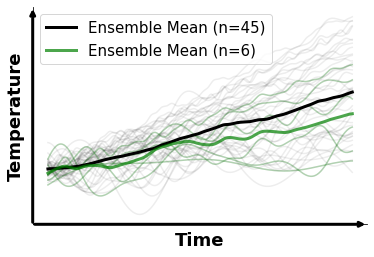

In [88]:
ax = fig.add_subplot(grid[1, 0])
x, y = create_xy(5)
x = np.linspace(2015, 2100, 890)
ys = []

for i in np.arange(2.5, 25, 0.5):
    __, y = create_xy(i)
    ys.append(y)
    plt.plot(x, y, color ='k', alpha =0.07)

ys = np.array(ys)
ys2 = []

for i in [2.5,5, 8, 12, 16, 18]:
    __, y = create_xy(i)
    ys2.append(y)
    plt.plot(x, y, color ='green',ls ='-', alpha =0.25)

ys2 = np.array(ys2)

plt.plot(x,ys.mean(0), color ='k', lw =3, label ='Ensemble Mean (n=45)')
plt.plot(x,ys2.mean(0), color ='green', lw =3, label ='Ensemble Mean (n=6)', alpha =0.7)

ax = plt.gca()

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_ticks_position('none')
ax.set_xlabel('Time', fontsize =18, weight= 'bold')
ax.set_ylabel('Temperature', fontsize =18, weight='bold')# Hide the labels and ticks
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.tick_params(axis='both', which='both', length=0)
ax.legend(fontsize =15)

# Show arrows at ends of the plot in place of spines
# Increase thickness by setting 'lw' parameter to 3. Default is 1.
ax.annotate('', xy=(1, 0), xycoords='axes fraction', xytext=(0, 0),
            arrowprops=dict(arrowstyle="->", color='k', lw=3))

ax.annotate('', xy=(0, 1), xycoords='axes fraction', xytext=(0, 0),
            arrowprops=dict(arrowstyle="->", color='k', lw=3))
#plt.savefig(r'C:\Users\rampaln\OneDrive - NIWA\Research Papers\Review Paper for AI approaches/Figure2_ensemble_pathways.png', dpi =500, bbox_inches ='tight')
plt.show()

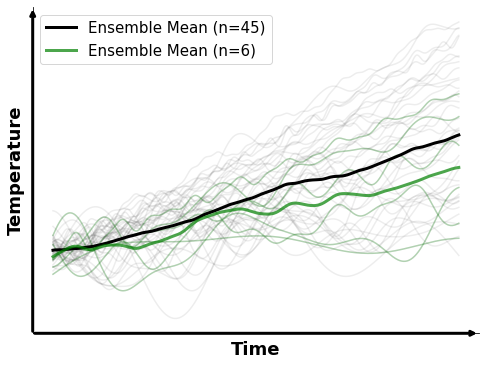

In [87]:

# plt.figure(figsize =(8, 6))
# x, y = create_xy(5)
# x = np.linspace(2015, 2100, 890)
# ys = []
# for i in np.arange(2.5, 25, 0.5):
#     __, y = create_xy(i)
#     ys.append(y)
#     plt.plot(x, y, color ='b', alpha =0.07)
#    # plt.title('Smooth Curve with Random Frequencies')
#     plt.xlabel('x')
#     plt.ylabel('y')
# ys = np.array(ys)
# ys2 = []
# for i in [2.5,5, 8, 12, 16, 18]:
#     __, y = create_xy(i)
#     ys2.append(y)
#     plt.plot(x, y, color ='r', alpha =0.35)
#     #plt.title('Smooth Curve with Random Frequencies')
#     plt.xlabel('x')
#     plt.ylabel('y')

# ys2 = np.array(ys2)

# plt.plot(x,ys.mean(0), color ='b', lw =3, label ='Ensemble Mean (n=45)')
# plt.plot(x,ys2.mean(0), color ='r', lw =3, label ='Ensemble Mean (n=6)')

# plt.yticks(np.arange(0, 30, 5), np.arange(0, 30, 5) * 0.2)
# plt.ylabel(r'$\delta$ Mean Temperature (K)', weight ='bold', fontsize =15)
# plt.tick_params(labelsize =15)
# plt.xticks(np.arange(2020, 2120, 20),np.arange(2020, 2120, 20))
# plt.xlabel('')
# plt.legend(fontsize=15)
# plt.xlim(2015, 2100)




#
# plt.annotate(
#     '', xy=(2105, ys[-1].min()), xycoords='data',
#     xytext=(2105, ys[-1].max()), textcoords='data',
#     arrowprops=dict(arrowstyle='<->', color='blue', lw=1.5)
# )
#
# plt.annotate(a
#     '', xy=(2101, ys2[-1].min()+1.25), xycoords='data',
#     xytext=(2101, ys2[-1].max()+0.75), textcoords='data',
#     arrowprops=dict(arrowstyle='<->', color='red', lw=1.5)
# )
#plt.savefig(r'C:\Users\rampaln\OneDrive - NIWA\Research Papers\Review Paper for AI approaches/test_fig.png', dpi =300)
#plt.show()

# import seaborn as sns
# x = np.random.randn(10000)*(0.01) + 0.007
# fig, ax = plt.subplots()
# sns.histplot(x, ax = ax)
# fig.show()




plt.figure(figsize =(8, 6))
x, y = create_xy(5)
x = np.linspace(2015, 2100, 890)
ys = []

for i in np.arange(2.5, 25, 0.5):
    __, y = create_xy(i)
    ys.append(y)
    plt.plot(x, y, color ='k', alpha =0.07)

ys = np.array(ys)
ys2 = []

for i in [2.5,5, 8, 12, 16, 18]:
    __, y = create_xy(i)
    ys2.append(y)
    plt.plot(x, y, color ='green',ls ='-', alpha =0.25)

ys2 = np.array(ys2)

plt.plot(x,ys.mean(0), color ='k', lw =3, label ='Ensemble Mean (n=45)')
plt.plot(x,ys2.mean(0), color ='green', lw =3, label ='Ensemble Mean (n=6)', alpha =0.7)

ax = plt.gca()

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_ticks_position('none')
ax.set_xlabel('Time', fontsize =18, weight= 'bold')
ax.set_ylabel('Temperature', fontsize =18, weight='bold')# Hide the labels and ticks
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.tick_params(axis='both', which='both', length=0)
ax.legend(fontsize =15)

# Show arrows at ends of the plot in place of spines
# Increase thickness by setting 'lw' parameter to 3. Default is 1.
ax.annotate('', xy=(1, 0), xycoords='axes fraction', xytext=(0, 0),
            arrowprops=dict(arrowstyle="->", color='k', lw=3))

ax.annotate('', xy=(0, 1), xycoords='axes fraction', xytext=(0, 0),
            arrowprops=dict(arrowstyle="->", color='k', lw=3))
#plt.savefig(r'C:\Users\rampaln\OneDrive - NIWA\Research Papers\Review Paper for AI approaches/Figure2_ensemble_pathways.png', dpi =500, bbox_inches ='tight')
plt.show()






AttributeError: 'list' object has no attribute 'mean'

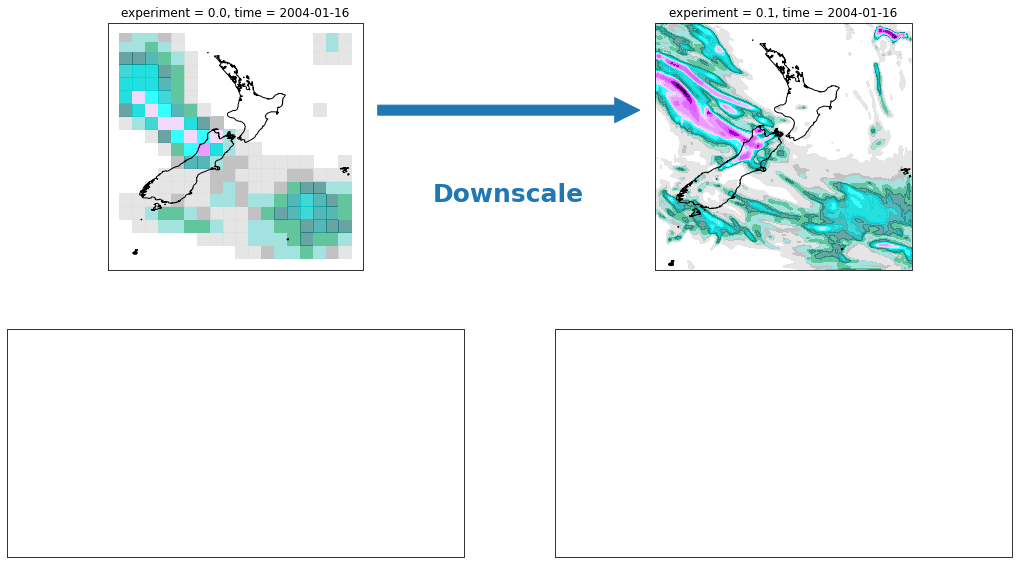

<Figure size 576x432 with 0 Axes>

In [65]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches 
import cartopy.crs as ccrs  
import numpy as np 

# ------------------ Plot 1: The Cartopy Map Plot ------------------ 

fig, gs = plt.subplots(2, 2, figsize=(18, 10),  # Enlarged for better layout
                       subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=171.77)))

# --- Plot 1 (gs[0,:2]): Coarse GCM Precipitation (spans top row) ---
dsets.sel(time="2004-01-16").isel(member=0, experiment=0).pr.coarsen(lat=10, lon=10, boundary='pad').mean().plot(
    cmap=cmap, norm=norm, 
    ax=gs[0, 0], transform=ccrs.PlateCarree(), extend='max', add_colorbar=False
)
gs[0, 0].coastlines('10m') 

# --- Plot 2: GCM Precipitation Contours ---
dsets.sel(time="2004-01-16").isel(member=0, experiment=-1).pr.plot.contourf(
    cmap=cmap, norm=norm, ax=gs[0, 1], transform=ccrs.PlateCarree(), extend='max', add_colorbar=False
)
gs[0, 1].coastlines('10m')

# ... (Rest of your Cartopy plot code: pressure contours, titles, extents) ...

# Arrow and Label 
x_tail = gs[0, 0].get_position().x1 + 0.01
x_head = gs[0, 1].get_position().x0 - 0.01
y_middle = (gs[0, 0].get_position().y0 + gs[0, 1].get_position().y1) / 2 + 0.05

arrow = mpatches.FancyArrowPatch((x_tail, y_middle), (x_head, y_middle),
                                 mutation_scale=50, 
                                 color='tab:blue')
fig.add_artist(arrow)

fig.text((x_tail + x_head) / 2, y_middle - 0.1, "Downscale", 
         ha='center', va='top', fontsize=25, color='tab:blue', weight='bold')


# ------ Plot 2: Temperature Ensemble Pathways  (gs[1, :]) ------

def create_xy(i):
    # ... (Your existing function code) ...
    return x, y  # Return both x and y for later use

plt.figure(figsize=(8, 6))  # Previous figure - remove, we'll plot directly on the grid

x, y = create_xy(5)  # Get shared x data
x = np.linspace(2015, 2100, 890)
ys = []

# ... (Your code to generate ensemble data) ...

# Plot ensemble pathways on grid subplot gs[1, 0]
gs[1, 0].plot(x, ys.mean(0), color='k', lw=3, label='Ensemble Mean (n=45)')
gs[1, 0].plot(x, ys2.mean(0), color='green', lw=3, label='Ensemble Mean (n=6)', alpha=0.7)

# ... (Customize axes, labels, arrows as before) ...

# Plot additional data on gs[1, 1] if needed

plt.tight_layout()  # Adjust layout for better spacing
plt.show()


In [45]:
import xarray as xr
df = xr.open_dataset(r'/nesi/project/niwa00018/ML_downscaling_CCAM/Training_CNN/inputs/Processed_CMIP6_DATA/Processed_ACCESS-CM2_ssp585.nc')
era5_data = xr.open_dataset(r'/nesi/project/niwa00018/ML_downscaling_CCAM/Training_CNN/inputs/ERA5/ERA5_training_dataset_5_3_24_remapcon.nc')

In [46]:
era5_data = xr.open_dataset(r'/nesi/project/niwa00018/ML_downscaling_CCAM/Training_CNN/inputs/ERA5/ERA5_training_dataset_5_3_24_remapcon.nc')

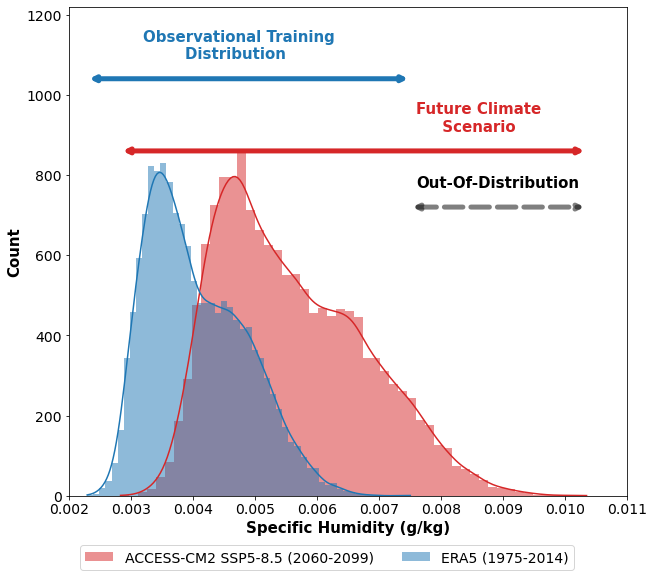

In [262]:
import seaborn as sns
fig, ax = plt.subplots(figsize = (10, 9))
bins = np.arange(0, 0.01, 0.0003)
sns.histplot(df.q_850.sel(time = slice("2060","2099")).mean(["lat","lon"]).values.ravel(), ax =ax, kde=True, color ='tab:red', label ='ACCESS-CM2 SSP5-8.5 (2060-2099)',ec=None, alpha =0.5, lw =10)
sns.histplot(era5_data.q_850.sel(time = slice("1975","2014")).mean(["lat","lon"]).values.ravel(), ax = ax, kde =True, color ='tab:blue', label ='ERA5 (1975-2014)',ec=None, alpha =0.5, lw =10)
ax.annotate('', xy=(era5_data.q_850.sel(time = slice("1975","2014")).mean(["lat","lon"]).max(), 1000+40), xycoords='data', xytext=(era5_data.q_850.sel(time = slice("1975","2014")).mean(["lat","lon"]).min(), 1000+40),
            arrowprops=dict(arrowstyle="<->", color='tab:blue', lw=5))
ax.annotate('', xy=(df.q_850.sel(time = slice("2060","2099")).mean(["lat","lon"]).max(), 820+40), xycoords='data', xytext=(df.q_850.sel(time = slice("2060","2099")).mean(["lat","lon"]).min(), 820+40),
            arrowprops=dict(arrowstyle="<->", color='tab:red', lw=5))
ax.annotate('', xy=(df.q_850.sel(time = slice("2060","2099")).mean(["lat","lon"]).max(), 680+40), xycoords='data', xytext=(era5_data.q_850.sel(time = slice("1975","2014")).mean(["lat","lon"]).max(), 680+40),
            arrowprops=dict(arrowstyle="<->", color='k', lw=5, ls ='--', alpha =0.5), alpha =0.5)
#ax.axvline(era5_data.q_850.sel(time = slice("1975","2014")).mean(["lat","lon"]).max(), color ='tab:blue', ls ='--', lw =4)
#x.axvline(era5_data.q_850.sel(time = slice("1975","2014")).mean(["lat","lon"]).min(), color ='tab:blue', ls ='--', lw =4)
ax.set_ylim(0,1220)
ax.text(0.0032, 1050+40, 'Observational Training \n        Distribution', fontsize =15, color ='tab:blue', weight ='bold')
ax.text(0.0076, 870+40, 'Future Climate \n     Scenario', fontsize =15, color ='tab:red', weight ='bold')
ax.text(0.0076, 730+40, 'Out-Of-Distribution', fontsize =15, color ='k', weight ='bold')
#ax.text(0.0078, 950, 'Future Climate \n     Scenario', fontsize =15, color ='tab:red', weight ='bold')
#ax.axvline(df.q_850.sel(time = slice("2070","2099")).mean(["lat","lon"]).max(), color ='tab:red', ls ='--', lw =4)
#ax.axvline(df.q_850.sel(time = slice("2070","2099")).mean(["lat","lon"]).min(), color ='tab:red', ls ='--', lw =4)
#fig.add_artist(arrow)
ax.set_xlim(0.002, 0.011)

ax.tick_params(labelsize = 14)
ax.set_xlabel('Specific Humidity (g/kg)', weight ='bold', fontsize =15)
ax.set_ylabel('Count', weight ='bold', fontsize =15)
fig.legend(loc ='lower center', ncol =2, fontsize =14)
#sns.displot(era5_data.q_850.sel(time = slice("1975","2014")).mean(["lat","lon"]).values.ravel(), color ='r')

In [32]:
pressure_fields = xr.open_dataset(r'//nesi/project/niwa00018/ML_downscaling_CCAM/multi-variate-gan/inputs/target_fields/ACCESS-CM2_hist_ssp370_pr_psl_tasmin_tasmax_sfcwind_sfcwindmax.nc')
pressure_fields['time'] = pd.to_datetime(pressure_fields.time.dt.strftime('%Y-%m-%d'))

In [33]:
# Example usage:
vegt, orog, he = load_and_normalize_topography_data(filepath)
# Example usage:
df_raw, df, y = load_and_concatenate_hist(model)
stacked_X = normalize_and_stack(df, means_filepath, stds_filepath, variables)
common_time = stacked_X.time.to_index().intersection(y.time.to_index())

Max orog: 1733.3603515625, Max he: 1157.462646484375, Max vegt: 17.00000762939453


## Defining a Custom Colorscale for some plots

In [44]:
boundaries2 = [0, 5,12.5, 15, 20, 25,30, 35, 40, 50, 60, 70, 80, 100, 125, 150, 200, 250]
colors2 = [[0.000, 0.000, 0.000, 0.000], [0.875, 0.875, 0.875, 0.784],\
          [0.761, 0.761, 0.761, 1.000], [0.639, 0.886, 0.871, 1.000], [0.388, 0.773, 0.616, 1.000],\
          [0.000, 0.392, 0.392, 0.588], [0.000, 0.576, 0.576, 0.667], [0.000, 0.792, 0.792, 0.745],\
          [0.000, 0.855, 0.855, 0.863], [0.212, 1.000, 1.000, 1.000], [0.953, 0.855, 0.992, 1.000],\
          [0.918, 0.765, 0.992, 1.000], [0.918, 0.612, 1.000, 1.000], [0.878, 0.431, 1.000, 1.000],\
          [0.886, 0.349, 1.000, 1.000], [0.651, 0.004, 0.788, 1.000], [0.357, 0.008, 0.431, 1.000],\
          [0.180, 0.000, 0.224, 1.000]]
#reviated for clarity

# Create the colormap using ListedColormap
cmap = mcolors.ListedColormap(colors2)
norm = mcolors.BoundaryNorm(boundaries2, cmap.N)

## A plot to highlight the ensemble spread

In [18]:

time = '2004-01-16'

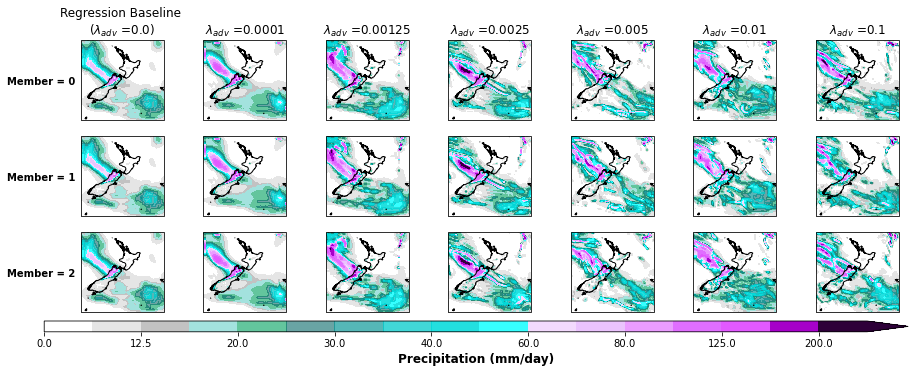

In [37]:

fig, ax = plt.subplots(3,7, figsize = (15, 5), subplot_kw = dict(projection = ccrs.PlateCarree(central_longitude =171.77)))
pressure_field_hpa = pressure_fields.sel(time =time).psl/ 100
#ax = ax.T
levels = np.arange(0,7, 0.2)
for j in range(7):
    
    ens_mean = dsets.sel(time =time).isel(experiment =j).mean("member")
    for i in range(3):

        pcor = xr.corr(ens_mean.stack(z=['lat','lon']).pr, dsets.sel(time =time).sel(lat = slice(-45, -35), 
                                                                                                                   lon = slice(167, 180)).isel(experiment =j, member =i).stack(z=['lat','lon']).compute().pr, dim ="z").compute()
        mae = abs(ens_mean.stack(z=['lat','lon']).pr.where(ens_mean.stack(z=['lat','lon']).pr>0, np.nan) - dsets.sel(time =time).isel(experiment =j, member =i).stack(z=['lat','lon'])).compute().pr.compute().mean()
        cs = dsets.sel(time =time).isel(member =i, experiment =j).pr.plot.contourf( cmap = cmap, norm = norm, ax = ax[i,j], add_colorbar =False, transform = ccrs.PlateCarree(), extend ='max', zorder =1)
        
    #     ax[i,j].text(166.5, -44, f"MAE\n{'%.2f' % mae.values}\nPCOR\n{'%.2f' % pcor.values}", weight='bold',
    # transform = ccrs.PlateCarree(), color ='red',  bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.25', zorder =16),
    # fontsize =7)
        ax[i,j].set_xlabel('')
        ax[i,j].set_ylabel('')
        ax[i,j].coastlines('10m')
        # contour_plot = pressure_field_hpa.plot.contour(colors='k', levels=range(980, 1030, 1), ax = ax[i,j], transform = ccrs.PlateCarree(), alpha =0.3, zorder =15)
        # contour_labels = plt.clabel(contour_plot, inline=True, fontsize=6, fmt='%1.0f')

                

        

        # Plot contours with a single color and labels every 5 hPa

        ax[i,j].set_title('')
        if i ==0:
            ax[i,j].set_title('$\lambda_{adv}$ =' + str(dsets.experiment.values[j]))
        if j ==0:
            ax[i,j].text(148, -43, f'Member = {i}', weight ='bold', transform = ccrs.PlateCarree())
        if (i ==0) & (j ==0):
            ax[i,j].set_title('Regression Baseline \n($\lambda_{adv}$ =' + str(dsets.experiment.values[j]) +")")
        

ax4 = fig.add_axes([0.1, 0.07, 0.8, 0.03])



cbar = fig.colorbar(cs, cax = ax4, orientation ='horizontal') 
# #cbar.set_ticks([0, 1, 2, 3, 4, 5 ,6, 7])
# #cbar.set_ticklabels([0, 1, 2, 3, 4, 5 ,6, 7])
cbar.set_label('Precipitation (mm/day)', fontsize = 12, weight ='bold')
#fig.tight_layout()
fig.savefig('/nesi/project/niwa00018/ML_downscaling_CCAM/training_GAN/figures/overall_results/examples_of_dispersion_base_model_v4_v2_updated_figure_v2.png', dpi =500, bbox_inches ='tight')
        #ax[i,j]

In [66]:
time

'2004-01-16'

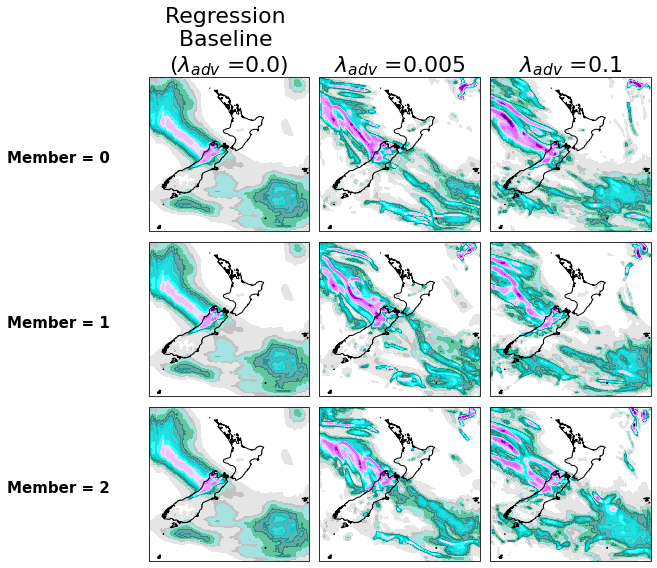

In [61]:

fig, ax = plt.subplots(3,3, figsize = (9, 8), subplot_kw = dict(projection = ccrs.PlateCarree(central_longitude =171.77)))
pressure_field_hpa = pressure_fields.sel(time =time).psl/ 100
#ax = ax.T
lambdas = [0,4, -1]
levels = np.arange(0,7, 0.2)
for j in range(3):
    
    ens_mean = dsets.sel(time =time).isel(experiment =lambdas[j]).mean("member")
    for i in range(3):

        pcor = xr.corr(ens_mean.stack(z=['lat','lon']).pr, dsets.sel(time =time).sel(lat = slice(-45, -35), 
                                                                                                                   lon = slice(167, 180)).isel(experiment =lambdas[j], member =i).stack(z=['lat','lon']).compute().pr, dim ="z").compute()
        mae = abs(ens_mean.stack(z=['lat','lon']).pr.where(ens_mean.stack(z=['lat','lon']).pr>0, np.nan) - dsets.sel(time =time).isel(experiment =lambdas[j], member =i).stack(z=['lat','lon'])).compute().pr.compute().mean()
        cs = dsets.sel(time =time).isel(member =i, experiment =lambdas[j]).pr.plot.contourf( cmap = cmap, norm = norm, ax = ax[i,j], 
                                                                                            add_colorbar =False, transform = ccrs.PlateCarree(), extend ='max', zorder =1)
        
    #     ax[i,j].text(166.5, -44, f"MAE\n{'%.2f' % mae.values}\nPCOR\n{'%.2f' % pcor.values}", weight='bold',
    # transform = ccrs.PlateCarree(), color ='red',  bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.25', zorder =16),
    # fontsize =7)
        ax[i,j].set_xlabel('')
        ax[i,j].set_ylabel('')
        ax[i,j].coastlines('10m')
        # contour_plot = pressure_field_hpa.plot.contour(colors='k', levels=range(980, 1030, 1), ax = ax[i,j], transform = ccrs.PlateCarree(), alpha =0.3, zorder =15)
        # contour_labels = plt.clabel(contour_plot, inline=True, fontsize=6, fmt='%1.0f')

                

        

        # Plot contours with a single color and labels every 5 hPa

        ax[i,j].set_title('')
        if i ==0:
            ax[i,j].set_title('$\lambda_{adv}$ =' + str(dsets.experiment.values[lambdas[j]]), fontsize =22)
        if j ==0:
            ax[i,j].text(148, -43, f'Member = {i}', weight ='bold', transform = ccrs.PlateCarree(), fontsize =15)
        if (i ==0) & (j ==0):
            ax[i,j].set_title('Regression \nBaseline \n($\lambda_{adv}$ =' + str(dsets.experiment.values[lambdas[j]]) +")", fontsize =22)
        

#ax4 = fig.add_axes([0.1, 0.07, 0.8, 0.03])



#cbar = fig.colorbar(cs, cax = ax4, orientation ='horizontal') 
# #cbar.set_ticks([0, 1, 2, 3, 4, 5 ,6, 7])
# #cbar.set_ticklabels([0, 1, 2, 3, 4, 5 ,6, 7])
cbar.set_label('Precipitation (mm/day)', fontsize = 18, weight ='bold')
fig.tight_layout()
#fig.tight_layout()
fig.savefig('/nesi/project/niwa00018/ML_downscaling_CCAM/training_GAN/figures/overall_results/examples_of_dispersion_final_withoutcbar.png', dpi =500, bbox_inches ='tight')
fig.savefig('/nesi/project/niwa00018/ML_downscaling_CCAM/training_GAN/figures/overall_results/examples_of_dispersion_final_withoutcbar.pdf', dpi =500, bbox_inches ='tight')
        #ax[i,j]

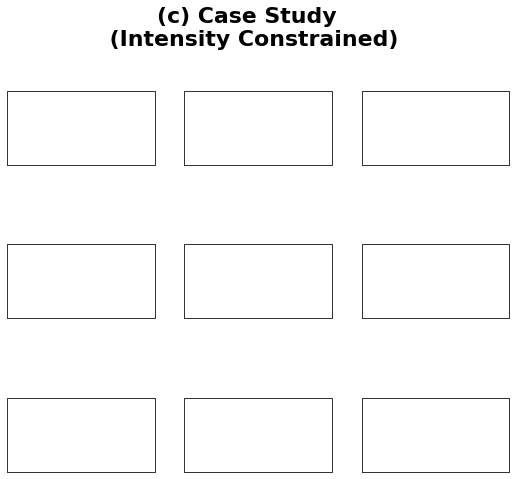

In [82]:
fig

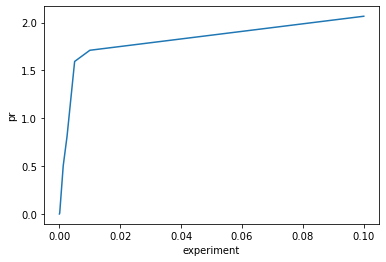

In [81]:
dsets.std("member").mean(["time","lat","lon"]).pr.plot()

In [ ]:

fig, ax = plt.subplots(3,3, figsize = (9, 8), subplot_kw = dict(projection = ccrs.PlateCarree(central_longitude =171.77)))
pressure_field_hpa = pressure_fields.sel(time =time).psl/ 100
#ax = ax.T
lambdas = [0,4, -1]
levels = np.arange(0,7, 0.2)
for j in range(3):
    
    ens_mean = dsets.sel(time =time).isel(experiment =lambdas[j]).mean("member")
    for i in range(3):

        pcor = xr.corr(ens_mean.stack(z=['lat','lon']).pr, dsets.sel(time =time).sel(lat = slice(-45, -35), 
                                                                                                                   lon = slice(167, 180)).isel(experiment =lambdas[j], member =i).stack(z=['lat','lon']).compute().pr, dim ="z").compute()
        mae = abs(ens_mean.stack(z=['lat','lon']).pr.where(ens_mean.stack(z=['lat','lon']).pr>0, np.nan) - dsets.sel(time =time).isel(experiment =lambdas[j], member =i).stack(z=['lat','lon'])).compute().pr.compute().mean()
        cs = dsets.sel(time =time).isel(member =i, experiment =lambdas[j]).pr.plot.contourf( cmap = cmap, norm = norm, ax = ax[i,j], 
                                                                                            add_colorbar =False, transform = ccrs.PlateCarree(), extend ='max', zorder =1)
        
    #     ax[i,j].text(166.5, -44, f"MAE\n{'%.2f' % mae.values}\nPCOR\n{'%.2f' % pcor.values}", weight='bold',
    # transform = ccrs.PlateCarree(), color ='red',  bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.25', zorder =16),
    # fontsize =7)
        ax[i,j].set_xlabel('')
        ax[i,j].set_ylabel('')
        ax[i,j].coastlines('10m')
        # contour_plot = pressure_field_hpa.plot.contour(colors='k', levels=range(980, 1030, 1), ax = ax[i,j], transform = ccrs.PlateCarree(), alpha =0.3, zorder =15)
        # contour_labels = plt.clabel(contour_plot, inline=True, fontsize=6, fmt='%1.0f')

                

        

        # Plot contours with a single color and labels every 5 hPa

        ax[i,j].set_title('')
        if i ==0:
            ax[i,j].set_title('$\lambda_{adv}$ =' + str(dsets.experiment.values[lambdas[j]]), fontsize =22)
        if j ==0:
            ax[i,j].text(148, -43, f'Member = {i}', weight ='bold', transform = ccrs.PlateCarree(), fontsize =15)
        if (i ==0) & (j ==0):
            ax[i,j].set_title('Regression \nBaseline \n($\lambda_{adv}$ =' + str(dsets.experiment.values[lambdas[j]]) +")", fontsize =22)
        

#ax4 = fig.add_axes([0.1, 0.07, 0.8, 0.03])



#cbar = fig.colorbar(cs, cax = ax4, orientation ='horizontal') 
# #cbar.set_ticks([0, 1, 2, 3, 4, 5 ,6, 7])
# #cbar.set_ticklabels([0, 1, 2, 3, 4, 5 ,6, 7])
cbar.set_label('Precipitation (mm/day)', fontsize = 18, weight ='bold')
fig.tight_layout()
#fig.tight_layout()
fig.savefig('/nesi/project/niwa00018/ML_downscaling_CCAM/training_GAN/figures/overall_results/examples_of_dispersion_final_withoutcbar.png', dpi =500, bbox_inches ='tight')
fig.savefig('/nesi/project/niwa00018/ML_downscaling_CCAM/training_GAN/figures/overall_results/examples_of_dispersion_final_withoutcbar.pdf', dpi =500, bbox_inches ='tight')
        #ax[i,j]

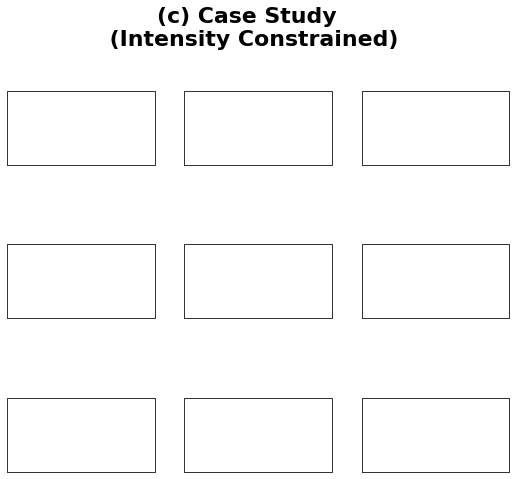

In [65]:
fig, ax = plt.subplots(3,3, figsize = (9, 8), subplot_kw = dict(projection = ccrs.PlateCarree(central_longitude =171.77)))
fig.suptitle('(c) Case Study \n (Intensity Constrained)', weight ='bold', fontsize =22)
#fig.tight_layout()
fig.savefig('/nesi/project/niwa00018/ML_downscaling_CCAM/training_GAN/figures/overall_results/examples_of_dispersion_title.png', dpi =500, bbox_inches ='tight')
#fig.savefig('/nesi/project/niwa00018/ML_downscaling_CCAM/training_GAN/figures/overall_results/examples_of_dispersion_final_withoutcbar.pdf', dpi =500, bbox_inches ='tight')

# A plot to show ground truth for the same example

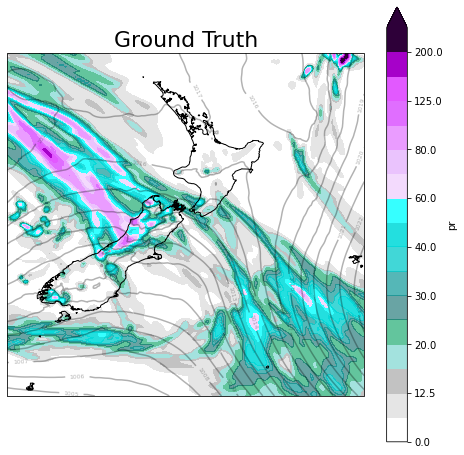

In [54]:
fig, ax = plt.subplots(subplot_kw = dict(projection = ccrs.PlateCarree(central_longitude =171.77)), figsize = (8,8))
time = '2004-01-16'
pressure_field_hpa = pressure_fields.sel(time =time).psl/ 100
y.sel(time = time).pr.plot.contourf( cmap = cmap, norm = norm, transform = ccrs.PlateCarree(), ax = ax, extend ='max')
ax.coastlines('10m')
contour_plot = pressure_field_hpa.plot.contour(colors='k', levels=range(980, 1030, 1), ax = ax, transform = ccrs.PlateCarree(), alpha =0.3, zorder =15)
contour_labels = plt.clabel(contour_plot, inline=True, fontsize=6, fmt='%1.0f')
ax.set_title('')
ax.set_title('Ground Truth', fontsize =22)
fig.savefig('/nesi/project/niwa00018/ML_downscaling_CCAM/training_GAN/figures/overall_results/examples_of_dispersion_ground_truth_final.png', dpi =500, bbox_inches ='tight')
fig.savefig('/nesi/project/niwa00018/ML_downscaling_CCAM/training_GAN/figures/overall_results/examples_of_dispersion_ground_truth_final.pdf', dpi =500, bbox_inches ='tight')
 

# Computing Power Spectral Density

In [35]:
import numpy as np
from scipy.stats import binned_statistic, binned_statistic_dd

def psd(y, bins=np.arange(0, 0.52, 0.02)):
    """
    Compute Power Spectral Density (PSD) of an image y.

    Args:
    - y: Input image with shape (time, lat, lon).
    - bins: Array of bin edges for binning the wavenumbers.

    Returns:
    - psd_array: Array of PSD values with shape (time, K), where K is sqrt(kx^2 + ky^2),
                 representing the wavenumber in X and Y.

    - bin_edges: Bin edges used for binning the wavenumbers.
    """
    # Compute 2D FFT of the input image
    ffts = np.fft.fft2(y)
    ffts = np.fft.fftshift(abs(ffts) ** 2)

    # Compute the frequency grids
    freq = np.fft.fftshift(np.fft.fftfreq(172))
    freq2 = np.fft.fftshift(np.fft.fftfreq(179))
    kx, ky = np.meshgrid(freq, freq2)
    kx = kx.T
    ky = ky.T

    # Compute PSD by binning wavenumbers
    x = [
        binned_statistic(
            np.sqrt(kx.ravel() ** 2 + ky.ravel() ** 2),
            values=np.vstack(ffts[i].ravel()).T,
            statistic="mean",
            bins=bins,
        ).statistic
        for i in range(ffts.shape[0])
    ]

    # Compute PSD for the last time step (for normalization)
    x2 = binned_statistic(
        np.sqrt(kx.ravel() ** 2 + ky.ravel() ** 2),
        values=np.vstack(ffts[-1].ravel()).T,
        statistic="mean",
        bins=bins,
    )

    # Normalize the PSD and return it along with bin edges
    return np.array(x)[:, 0, :] / abs(x2.bin_edges[0] - x2.bin_edges[1]), x2.bin_edges

# Concatenating Ground Truth with Historical

In [36]:
y_exp = y.sel(time = dsets.time).expand_dims({"experiment":1})
y_exp['experiment'] = (('experiment'), ['Ground Truth'])
concat_dsets_cat = xr.concat([dsets.isel(member =0), y_exp], dim ="experiment")
#concat_dsets_cat2 = xr.concat([dsets2, y.sel(time = dsets.time).expand_dims({"model":1})], dim ="model")

    

In [37]:
y_exp = y.sel(time = dsets.time).expand_dims({"experiment":1})
y_exp['experiment'] = (('experiment'), ['Ground Truth'])
concat_dsets_cat = xr.concat([dsets.isel(member =0), y_exp], dim ="experiment")
#concat_dsets_cat2 = xr.concat([dsets2, y.sel(time = dsets.time).expand_dims({"model":1})], dim ="model")

spatial_av = concat_dsets_cat.isel(experiment =-1).mean(["lat","lon"])
times = spatial_av.where(spatial_av >8,np.nan).dropna("time").time[:-1]

In [26]:
times

<xarray.DataArray 'time' ()>
array('2002-02-27T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2002-02-27

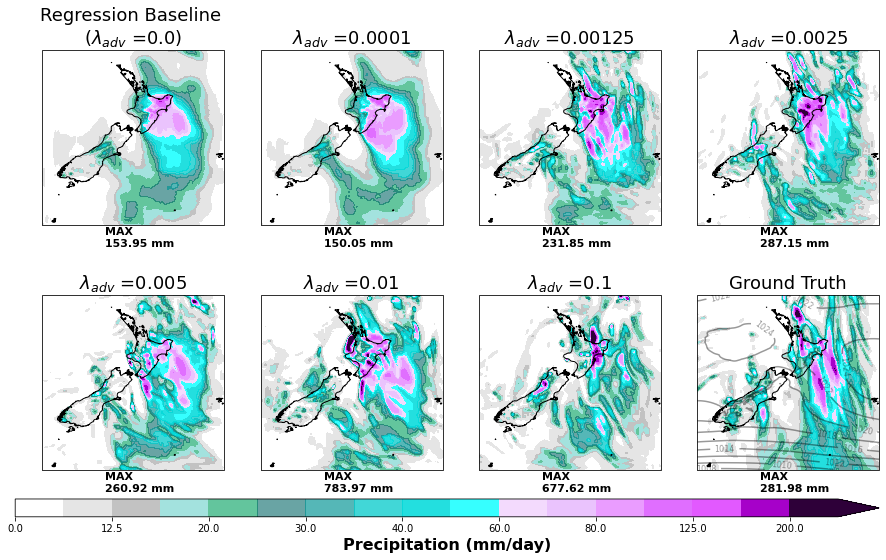

In [24]:
import matplotlib.colors as mcolors
spatial_av = y.mean(["lat","lon"])
times = spatial_av.where(spatial_av >16,np.nan).dropna("time").time[:-1]
times  = times[2]#pd.to_datetime(['2004-01-16'])


# Create the colormap using ListedColormap

# Define the norm with BoundaryNorm
norm = mcolors.BoundaryNorm(boundaries2, cmap.N)
fig, ax = plt.subplots(2,4, figsize = (15, 8.25), subplot_kw = dict(projection = ccrs.PlateCarree(central_longitude =171.77)))
ax = ax.ravel()
#ax = ax.T
levels = np.arange(0,7, 0.2)
for j in range(8):
    
    #ens_mean = dsets.sel(time =time).isel(experiment =j).mean("member")

    pressure_field_hpa = pressure_fields.sel(time =times).psl/ 100
        #pcor = xr.corr(ens_mean.stack(z=['lat','lon']).pr, dsets.sel(time =time).sel(lat = slice(-45, -35), 
                                                                                                                   #lon = slice(167, 180)).isel(experiment =j, member =i).stack(z=['lat','lon']).compute().pr, dim ="z").compute()
        #mae = abs(ens_mean.stack(z=['lat','lon']).pr.where(ens_mean.stack(z=['lat','lon']).pr>0, np.nan) - dsets.sel(time =time).isel(experiment =j, member =i).stack(z=['lat','lon'])).compute().pr.compute().mean()
    cs = concat_dsets_cat.sel(time =pd.to_datetime(times.values)).isel( experiment =j).pr.plot.contourf( cmap = cmap, norm = norm, ax = ax[j],
                                                                                                         add_colorbar =False, transform = ccrs.PlateCarree(), extend ='max', zorder =1)
    max_intensity = concat_dsets_cat.sel(time =pd.to_datetime(times.values)).isel( experiment =j).max(["lat","lon"])
    mean_iten = concat_dsets_cat.sel(time =pd.to_datetime(times.values)).isel( experiment =j).mean(["lat","lon"])
        
    #     ax[i,j].text(166.5, -44, f"MAE\n{'%.2f' % mae.values}\nPCOR\n{'%.2f' % pcor.values}", weight='bold',
    # transform = ccrs.PlateCarree(), color ='red',  bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.25', zorder =16),
    # fontsize =7)
    ax[j].set_xlabel('')
    ax[j].set_ylabel('')
    ax[j].coastlines('10m')
    if j ==7:
        contour_plot = pressure_field_hpa.plot.contour(colors='k', levels=range(980, 1030, 2), ax = ax[j], transform = ccrs.PlateCarree(), alpha =0.4, zorder =15)
        contour_labels = plt.clabel(contour_plot, inline=True, fontsize=8, fmt='%1.0f')
    ax[j].text(171.5, -53.5, f"MAX \n{'%.2f' % max_intensity.pr.values} mm", weight='bold',
    transform = ccrs.PlateCarree(), color ='k',
    fontsize =11)
                

        

        # Plot contours with a single color and labels every 5 hPa

    ax[j].set_title('')

    if j < 7:
        ax[j].set_title('$\lambda_{adv}$ =' + str(concat_dsets_cat.experiment.values[j]), fontsize =18)
    else:
        ax[j].set_title('Ground Truth', fontsize=18)
    if j ==0:
        ax[j].set_title('')
        ax[j].set_title('Regression Baseline \n($\lambda_{adv}$ =' + str(concat_dsets_cat.experiment.values[j])+")", fontsize =18)
    # if j ==0:
    #     ax[j].text(148, -43, f'{times.time.dt.strftime("%Y-%m-%d")}', weight ='bold', transform = ccrs.PlateCarree())
        

ax4 = fig.add_axes([0.1, 0.07, 0.8, 0.03])



cbar = fig.colorbar(cs, cax = ax4, orientation ='horizontal') 
# #cbar.set_ticks([0, 1, 2, 3, 4, 5 ,6, 7])
# #cbar.set_ticklabels([0, 1, 2, 3, 4, 5 ,6, 7])
cbar.set_label('Precipitation (mm/day)', fontsize = 16, weight ='bold')
#fig.tight_layout()
fig.savefig('/nesi/project/niwa00018/ML_downscaling_CCAM/training_GAN/figures/overall_results/examples_of_extreme_events_Figure3_v3_LeakyRelu.png', dpi =500, bbox_inches ='tight')
        #ax[i,j]

In [28]:
z =dsets.max(["time","lat","lon","member"]).pr

In [29]:
z

<xarray.DataArray 'pr' (experiment: 7)>
array([4.4527246e+02, 4.7702979e+02, 1.6446281e+03, 1.0866266e+03,
       1.9918011e+03, 4.9286426e+03, 5.4913565e+24], dtype=float32)
Coordinates:
  * experiment  (experiment) float64 0.0 0.0001 0.00125 0.0025 0.005 0.01 0.1

In [138]:

times = spatial_av.where(spatial_av >8,np.nan).dropna("time").time[:-1]
print(len(times))

215


# Computing the Power Spectral Density for the three most extreme events

In [35]:
xs_raw = []
for i, lambda_var in enumerate(concat_dsets_cat.experiment.values):
    x1, y1 = psd(concat_dsets_cat.sel(experiment =lambda_var, time =times[:200]).pr.values)
    xs_raw.append(x1)




In [38]:
xs = []
for i, lambda_var in enumerate(concat_dsets_cat.experiment.values):
    x1, y1 = psd((concat_dsets_cat.sel(experiment =lambda_var, time =times[:200]).pr.values - concat_dsets_cat.sel(experiment =lambda_var, time =times[:200]).pr.mean("time").values)/concat_dsets_cat.sel(experiment =lambda_var, time =times[:200]).pr.std("time").values)
    xs.append(x1)




In [47]:
import matplotlib

In [51]:
matplotlib.cm.BrBG

In [40]:
cmap = plt.cm.RdBu
marker_types = ['o', 's', '^', 'D', '*', 'x', 'P']
# Generate seven distinct colors, excluding white
colors = [cmap(i) for i in np.linspace(0,1, 25)]
colors_hist = [colors[0], colors[4], colors[7], colors[10], colors[17], colors[21], colors[-1]]

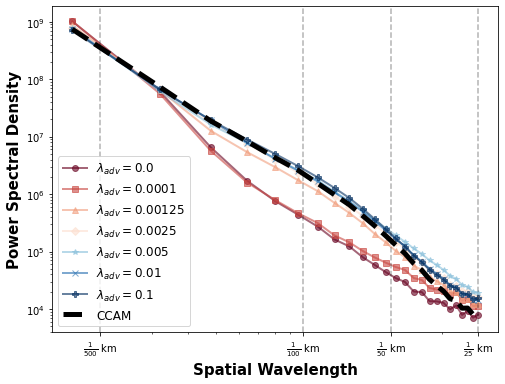

In [41]:

cmap = plt.cm.RdBu
marker_types = ['o', 's', '^', 'D', '*', 'x', 'P']
# Generate seven distinct colors, excluding white
colors = [cmap(i) for i in np.linspace(0,1, 25)]
colors_hist = [colors[0], colors[4], colors[7], colors[10], colors[17], colors[21], colors[-1]]
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Define the colors representing "dry" and "wet"

minimum_freq_in_ccam = 12.5
fig, ax = plt.subplots(figsize = (8, 6))
for i,lambdas_var in enumerate(concat_dsets_cat.experiment.values):
    if lambdas_var == "Ground Truth":
        ax.loglog(y1[1:]/minimum_freq_in_ccam, np.mean(xs[i], axis =0), color='k', lw=5, label='CCAM', ls ='--')
    else:
        # if i%2==0:
        # #color_str = "#{:02x}{:02x}{:02x}".format(*color_gradient[i])
        #     ax.loglog(y1[1:]/minimum_freq_in_ccam, np.mean(xs[i], axis =0),label ='$\lambda_{adv}=$' +f'{lambdas_var}', color = cmap(i*50), ls ='--')
        ax.loglog(y1[1:]/minimum_freq_in_ccam, np.mean(xs[i], axis =0),label ='$\lambda_{adv}=$' +f'{lambdas_var}', color = colors_hist[i], ls ='-', 
                  marker =marker_types[i], alpha =0.6, lw =2)

        #ax.axvline(max_values.sel(experiment = lambdas_var).pr.values, color  = color_str)
reciprocal_ticks = [25, 50, 100, 500]

# Compute frequency values from reciprocal values
frequency_ticks = [1 / tick for tick in reciprocal_ticks]

# Add vertical dashed lines at specified frequencies
[ax.axvline(frequency_ticks[i], color='k', ls='--', alpha=0.3) for i in range(len(frequency_ticks))]

# Add a legend
ax.legend(fontsize=12)

# Set the y-axis label and font properties
ax.set_ylabel('Power Spectral Density', weight='bold', fontsize=15)

# Set the x-axis label and font properties
ax.set_xlabel('Spatial Wavelength', weight='bold', fontsize=15)

# Convert frequency_ticks to strings with the desired format
frequency_labels = [f'$\\frac{{1}}{{{int(1/tick)}}}$ km' if int(1/tick) > 1 else '1 km' for tick in frequency_ticks]

# Set the x-axis ticks and labels
plt.xticks(frequency_ticks, frequency_labels)

# Add any other desired labels, titles, legends, etc.

# Show the plot
plt.show()
fig.savefig(r'/nesi/project/niwa00018/ML_downscaling_CCAM/training_GAN/figures/overall_results/psd_plot_norm_intensity_constraint.png', dpi =500, bbox_inches ='tight')
# a

In [12]:
import matplotlib.colors as mcolors
spatial_av = y.mean(["lat","lon"])
times = spatial_av.where(spatial_av >16,np.nan).dropna("time").time[:-1]
import cartopy.crs as ccrs
boundaries2 = [0, 5,12.5, 15, 20, 25,30, 35, 40, 50, 60, 70, 80, 100, 125, 150, 200, 250]
colors2 = [[0.000, 0.000, 0.000, 0.000], [0.875, 0.875, 0.875, 0.784],\
          [0.761, 0.761, 0.761, 1.000], [0.639, 0.886, 0.871, 1.000], [0.388, 0.773, 0.616, 1.000],\
          [0.000, 0.392, 0.392, 0.588], [0.000, 0.576, 0.576, 0.667], [0.000, 0.792, 0.792, 0.745],\
          [0.000, 0.855, 0.855, 0.863], [0.212, 1.000, 1.000, 1.000], [0.953, 0.855, 0.992, 1.000],\
          [0.918, 0.765, 0.992, 1.000], [0.918, 0.612, 1.000, 1.000], [0.878, 0.431, 1.000, 1.000],\
          [0.886, 0.349, 1.000, 1.000], [0.651, 0.004, 0.788, 1.000], [0.357, 0.008, 0.431, 1.000],\
          [0.180, 0.000, 0.224, 1.000]]
#reviated for clarity

# Create the colormap using ListedColormap
cmap = mcolors.ListedColormap(colors2)

# Define the norm with BoundaryNorm
norm = mcolors.BoundaryNorm(boundaries2, cmap.N)
fig, ax = plt.subplots(4,8, figsize = (15, 8), subplot_kw = dict(projection = ccrs.PlateCarree(central_longitude =171.77)))

#ax = ax.T
levels = np.arange(0,7, 0.2)
for j in range(8):
    
    #ens_mean = dsets.sel(time =time).isel(experiment =j).mean("member")
    for i in range(4):
        pressure_field_hpa = pressure_fields.sel(time =times[i]).psl/ 100
        #pcor = xr.corr(ens_mean.stack(z=['lat','lon']).pr, dsets.sel(time =time).sel(lat = slice(-45, -35), 
                                                                                                                   #lon = slice(167, 180)).isel(experiment =j, member =i).stack(z=['lat','lon']).compute().pr, dim ="z").compute()
        #mae = abs(ens_mean.stack(z=['lat','lon']).pr.where(ens_mean.stack(z=['lat','lon']).pr>0, np.nan) - dsets.sel(time =time).isel(experiment =j, member =i).stack(z=['lat','lon'])).compute().pr.compute().mean()
        cs = concat_dsets_cat.sel(time =pd.to_datetime(times[i].values)).isel( experiment =j).pr.plot.contourf( cmap = cmap, norm = norm, ax = ax[i,j], add_colorbar =False, transform = ccrs.PlateCarree(), extend ='max', zorder =1)
        max_intensity = concat_dsets_cat.sel(time =pd.to_datetime(times[i].values)).isel( experiment =j).max(["lat","lon"])
        mean_iten = concat_dsets_cat.sel(time =pd.to_datetime(times[i].values)).isel( experiment =j).mean(["lat","lon"])
        
    #     ax[i,j].text(166.5, -44, f"MAE\n{'%.2f' % mae.values}\nPCOR\n{'%.2f' % pcor.values}", weight='bold',
    # transform = ccrs.PlateCarree(), color ='red',  bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.25', zorder =16),
    # fontsize =7)
        ax[i,j].set_xlabel('')
        ax[i,j].set_ylabel('')
        ax[i,j].coastlines('10m')
        contour_plot = pressure_field_hpa.plot.contour(colors='k', levels=range(980, 1030, 2), ax = ax[i,j], transform = ccrs.PlateCarree(), alpha =0.4, zorder =15)
        contour_labels = plt.clabel(contour_plot, inline=True, fontsize=6, fmt='%1.0f')
        ax[i,j].text(171.5, -57, f"MAX \n{'%.2f' % max_intensity.pr.values} mm\nMEAN\n{'%.2f' %  mean_iten.pr.values} mm", weight='bold',
    transform = ccrs.PlateCarree(), color ='k',
    fontsize =7)
                

        

        # Plot contours with a single color and labels every 5 hPa

        ax[i,j].set_title('')
        if i ==0:
            if j < 7:
                ax[i,j].set_title('$\lambda_{adv}$ =' + str(concat_dsets_cat.experiment.values[j]))
            else:
                ax[i,j].set_title('Ground Truth')
        if j ==0:
            ax[i,j].text(148, -43, f'{times.time.dt.strftime("%Y-%m-%d").values[i]}', weight ='bold', transform = ccrs.PlateCarree())
        

ax4 = fig.add_axes([0.1, 0.07, 0.8, 0.03])



cbar = fig.colorbar(cs, cax = ax4, orientation ='horizontal') 
# #cbar.set_ticks([0, 1, 2, 3, 4, 5 ,6, 7])
# #cbar.set_ticklabels([0, 1, 2, 3, 4, 5 ,6, 7])
cbar.set_label('Precipitation (mm/day)', fontsize = 12, weight ='bold')
#fig.tight_layout()
fig.savefig('/nesi/project/niwa00018/ML_downscaling_CCAM/training_GAN/figures/Intensity_Penalty/examples_of_extreme_events_base.png', dpi =500, bbox_inches ='tight')
        #ax[i,j]

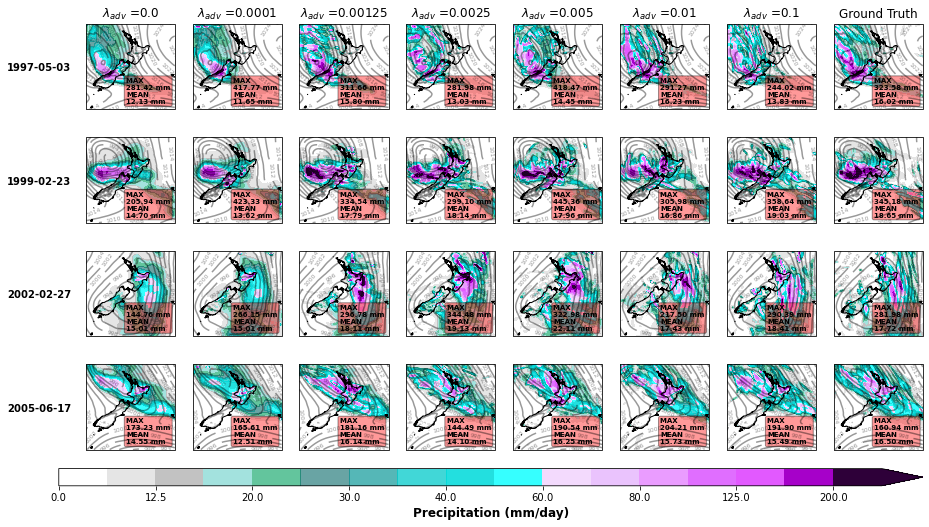

In [23]:
import matplotlib.colors as mcolors
spatial_av = y.mean(["lat","lon"])
times = spatial_av.where(spatial_av >16,np.nan).dropna("time").time[:-1]
import cartopy.crs as ccrs
boundaries2 = [0, 5,12.5, 15, 20, 25,30, 35, 40, 50, 60, 70, 80, 100, 125, 150, 200, 250]
colors2 = [[0.000, 0.000, 0.000, 0.000], [0.875, 0.875, 0.875, 0.784],\
          [0.761, 0.761, 0.761, 1.000], [0.639, 0.886, 0.871, 1.000], [0.388, 0.773, 0.616, 1.000],\
          [0.000, 0.392, 0.392, 0.588], [0.000, 0.576, 0.576, 0.667], [0.000, 0.792, 0.792, 0.745],\
          [0.000, 0.855, 0.855, 0.863], [0.212, 1.000, 1.000, 1.000], [0.953, 0.855, 0.992, 1.000],\
          [0.918, 0.765, 0.992, 1.000], [0.918, 0.612, 1.000, 1.000], [0.878, 0.431, 1.000, 1.000],\
          [0.886, 0.349, 1.000, 1.000], [0.651, 0.004, 0.788, 1.000], [0.357, 0.008, 0.431, 1.000],\
          [0.180, 0.000, 0.224, 1.000]]
#reviated for clarity

# Create the colormap using ListedColormap
cmap = mcolors.ListedColormap(colors2)

# Define the norm with BoundaryNorm
norm = mcolors.BoundaryNorm(boundaries2, cmap.N)
fig, ax = plt.subplots(4,8, figsize = (15, 8), subplot_kw = dict(projection = ccrs.PlateCarree(central_longitude =171.77)))

#ax = ax.T
levels = np.arange(0,7, 0.2)
for j in range(8):
    
    #ens_mean = dsets.sel(time =time).isel(experiment =j).mean("member")
    for i in range(4):
        pressure_field_hpa = pressure_fields.sel(time =times[i]).psl/ 100
        #pcor = xr.corr(ens_mean.stack(z=['lat','lon']).pr, dsets.sel(time =time).sel(lat = slice(-45, -35), 
                                                                                                                   #lon = slice(167, 180)).isel(experiment =j, member =i).stack(z=['lat','lon']).compute().pr, dim ="z").compute()
        #mae = abs(ens_mean.stack(z=['lat','lon']).pr.where(ens_mean.stack(z=['lat','lon']).pr>0, np.nan) - dsets.sel(time =time).isel(experiment =j, member =i).stack(z=['lat','lon'])).compute().pr.compute().mean()
        cs = concat_dsets_cat.sel(time =pd.to_datetime(times[i].values)).isel( experiment =j).pr.plot.contourf( cmap = cmap, norm = norm, ax = ax[i,j], add_colorbar =False, transform = ccrs.PlateCarree(), extend ='max', zorder =1)
        max_intensity = concat_dsets_cat.sel(time =pd.to_datetime(times[i].values)).isel( experiment =j).max(["lat","lon"])
        mean_iten = concat_dsets_cat.sel(time =pd.to_datetime(times[i].values)).isel( experiment =j).mean(["lat","lon"])
        
    #     ax[i,j].text(166.5, -44, f"MAE\n{'%.2f' % mae.values}\nPCOR\n{'%.2f' % pcor.values}", weight='bold',
    # transform = ccrs.PlateCarree(), color ='red',  bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.25', zorder =16),
    # fontsize =7)
        ax[i,j].set_xlabel('')
        ax[i,j].set_ylabel('')
        ax[i,j].coastlines('10m')
        contour_plot = pressure_field_hpa.plot.contour(colors='k', levels=range(980, 1030, 2), ax = ax[i,j], transform = ccrs.PlateCarree(), alpha =0.4, zorder =15)
        contour_labels = plt.clabel(contour_plot, inline=True, fontsize=6, fmt='%1.0f')
        ax[i,j].text(171.5, -57, f"MAX \n{'%.2f' % max_intensity.pr.values} mm\nMEAN\n{'%.2f' %  mean_iten.pr.values} mm", weight='bold',
    transform = ccrs.PlateCarree(), color ='k',
    fontsize =7)
                

        

        # Plot contours with a single color and labels every 5 hPa

        ax[i,j].set_title('')
        if i ==0:
            if j < 7:
                ax[i,j].set_title('$\lambda_{adv}$ =' + str(concat_dsets_cat.experiment.values[j]))
            else:
                ax[i,j].set_title('Ground Truth')
        if j ==0:
            ax[i,j].text(148, -43, f'{times.time.dt.strftime("%Y-%m-%d").values[i]}', weight ='bold', transform = ccrs.PlateCarree())
        

ax4 = fig.add_axes([0.1, 0.07, 0.8, 0.03])



cbar = fig.colorbar(cs, cax = ax4, orientation ='horizontal') 
# #cbar.set_ticks([0, 1, 2, 3, 4, 5 ,6, 7])
# #cbar.set_ticklabels([0, 1, 2, 3, 4, 5 ,6, 7])
cbar.set_label('Precipitation (mm/day)', fontsize = 12, weight ='bold')
#fig.tight_layout()
fig.savefig('/nesi/project/niwa00018/ML_downscaling_CCAM/training_GAN/figures/Intensity_Penalty/examples_of_extreme_events_base.png', dpi =500, bbox_inches ='tight')
        #ax[i,j]

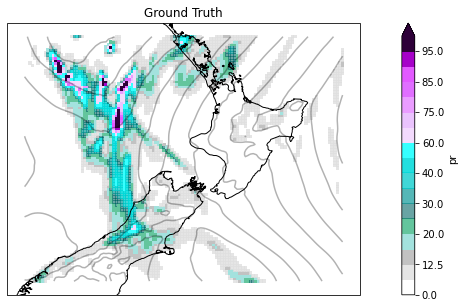

In [37]:
fig, ax = plt.subplots( figsize = (15, 5), subplot_kw = dict(projection = ccrs.PlateCarree(central_longitude =171.77)))
y.sel(time = dsets.time).isel(time = 134).sel(lat = slice(-45, -35), lon = slice(167, 180)).pr.plot(cmap = cmap, norm = norm, ax = ax, transform = ccrs.PlateCarree(),)
contour_plot = pressure_field_hpa.sel(lat = slice(-45, -35), lon = slice(167, 180)).plot.contour(colors='k', levels=range(980, 1030, 1), ax = ax, transform = ccrs.PlateCarree(), alpha =0.3, zorder =15)
ax.coastlines('10m')
ax.set_title('Ground Truth')
fig.savefig('/nesi/project/niwa00018/ML_downscaling_CCAM/training_GAN/figures/Intensity_Penalty/examples_of_dispersion_cascade_model_gt.png', dpi =500, bbox_inches ='tight')

In [27]:
concat_dsets_cat

<xarray.Dataset>
Dimensions:     (experiment: 8, lon: 179, lat: 172, time: 7300)
Coordinates:
  * experiment  (experiment) object 0.0 0.0001 0.00125 ... 0.1 'Ground Truth'
  * lon         (lon) float32 164.9 165.0 165.1 165.2 ... 183.7 183.9 184.0
  * lat         (lat) float32 -51.21 -51.11 -51.0 ... -33.07 -32.97 -32.86
  * time        (time) datetime64[ns] 1986-01-01 1986-01-02 ... 2005-12-31
Data variables:
    pr          (experiment, time, lat, lon) float32 0.8222 0.8702 ... 0.07396
Attributes: (12/19)
    source:          CSIRO conformal-cubic model. Input file: surf.ccam_12km....
    Conventions:     CF-1.7
    title:           CCAM simulation data
    contact:         ccam@csiro.au
    project:         Undefined CCAM project
    history:         Created on 2022-10-19 16:55:55
    ...              ...
    ms:              6
    ntrac:           0
    nproc:           864
    procmode:        10
    decomp:          face
    modeling_realm:  atmos

In [25]:
dsets

<xarray.Dataset>
Dimensions:     (experiment: 7, lon: 179, lat: 172, time: 7300, member: 10)
Coordinates:
  * experiment  (experiment) float64 0.0 0.0001 0.00125 0.0025 0.005 0.01 0.1
  * lon         (lon) float32 164.9 165.0 165.1 165.2 ... 183.7 183.9 184.0
  * lat         (lat) float32 -51.21 -51.11 -51.0 ... -33.07 -32.97 -32.86
  * time        (time) datetime64[ns] 1986-01-01 1986-01-02 ... 2005-12-31
Dimensions without coordinates: member
Data variables:
    pr          (experiment, member, time, lat, lon) float32 0.8222 ... 0.08262
Attributes: (12/19)
    source:          CSIRO conformal-cubic model. Input file: surf.ccam_12km....
    Conventions:     CF-1.7
    title:           CCAM simulation data
    contact:         ccam@csiro.au
    project:         Undefined CCAM project
    history:         Created on 2022-10-19 16:55:55
    ...              ...
    ms:              6
    ntrac:           0
    nproc:           864
    procmode:        10
    decomp:          face
    modeling_realm:  atmos

# Computing the distribution of the outputs

In [45]:
#stacked_vars = concat_dsets_cat.isel(member =0, time = slice(0,1000)).where(concat_dsets_cat.isel(member =0, time = slice(0,1000))>0, np.nan).stack(z =['time', 'lat','lon'])
stacked_vars = concat_dsets_cat.where(concat_dsets_cat>0, np.nan).stack(z =['time', 'lat','lon'])
with ProgressBar():
    stacked_vars = stacked_vars.compute()

In [39]:
from matplotlib.colors import LinearSegmentedColormap
colors = [(1, 0, 0), (1, 0.5, 0), (0.6, 0.3, 0), (0, 0.5, 0)]  # Red to Orange to Brown to Dark Green
cmap = LinearSegmentedColormap.from_list('custom_colors', colors, N=7)


In [76]:
stacked_vars.sel(experiment =lambdas_var).dropna("z").pr,

(<xarray.DataArray 'pr' (member: 10, z: 224752400)>
 array([[3.3046117 , 2.619933  , 2.498281  , ..., 0.0408204 , 0.03419671,
         0.04233037],
        [3.3046117 , 2.619933  , 2.498281  , ..., 0.0408204 , 0.03419671,
         0.04233037],
        [3.3046117 , 2.619933  , 2.498281  , ..., 0.0408204 , 0.03419671,
         0.04233037],
        ...,
        [3.3046117 , 2.619933  , 2.498281  , ..., 0.0408204 , 0.03419671,
         0.04233037],
        [3.3046117 , 2.619933  , 2.498281  , ..., 0.0408204 , 0.03419671,
         0.04233037],
        [3.3046117 , 2.619933  , 2.498281  , ..., 0.0408204 , 0.03419671,
         0.04233037]], dtype=float32)
 Coordinates:
     experiment  float64 0.0
   * z           (z) MultiIndex
   - time        (z) datetime64[ns] 1986-01-01 1986-01-01 ... 2005-12-31
   - lat         (z) float64 -51.21 -51.21 -51.21 -51.21 ... -32.86 -32.86 -32.86
   - lon         (z) float64 164.9 165.0 165.1 165.2 ... 183.6 183.7 183.9 184.0
 Dimensions without coordinates:

In [15]:
experiment

'LeakyRelu_Activation'

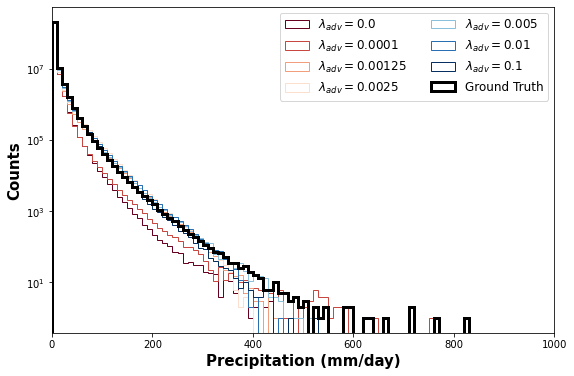

In [46]:
#plt.hist(values.pr[values.pr>0].values, bins = np.arange(0,600,10), histtype='step', color='blue')
#stacked_vars = concat_dsets_cat.where(concat_dsets_cat>0, np.nan).stack(z =['time', 'lat','lon'])
fig, ax = plt.subplots(figsize=(9, 6))
for i,lambdas_var in enumerate(stacked_vars.experiment.values):
    
    if lambdas_var == "Ground Truth":
        ax.hist(stacked_vars.sel(experiment =lambdas_var).dropna("z").pr.values, bins = np.arange(0,1010,10), histtype='step', label =f'{lambdas_var}', color ='k', ls ='-', lw =3)
    else:
        #color_str = "#{:02x}{:02x}{:02x}".format(*color_gradient[i])
        ax.hist(stacked_vars.sel(experiment =lambdas_var).dropna("z").pr.values, 
                bins = np.arange(0,1010,10), histtype='step', label ='$\lambda_{adv}=$' +f'{lambdas_var}', color = colors_hist[i], ls ='-')
        #ax.axvline(max_values.sel(experiment = lambdas_var).pr.values, color  = color_str)
# ax.hist(stacked_vars.isel(model =1).dropna("z").pr, bins = np.arange(0,700,10), histtype='step', color='blue',label = 'Cascade GAN')

# ax.hist(stacked_vars.isel(model =2).dropna("z").pr, bins = np.arange(0,700,10), histtype='step', color='r',label = 'CCAM')
ax.set_xlim(0,1000)
ax.set_yscale('log')
#plt.yscale('log')
ax.set_xlabel('Precipitation (mm/day)', fontsize =15, weight ='bold')
ax.set_ylabel('Counts', fontsize =15, weight ='bold')
ax.legend(fontsize =12, ncol =2)
fig.savefig(f'/nesi/project/niwa00018/ML_downscaling_CCAM/training_GAN/figures/overall_results/{experiment}_{model}_histogram_IP.png', dpi =500, bbox_inches ='tight')

In [47]:
z1 = y.sel(time=dsets.time).where(y.sel(time=dsets.time) > 0.05, np.nan).quantile(q=np.arange(0.0, 1.00, 0.01), dim ="time")
with ProgressBar():
    z2 = dsets.isel(member =0).where(dsets.isel(member =0) > 0.05, np.nan).quantile(q=np.arange(0.0, 1.00, 0.01), dim =["time"]).compute()

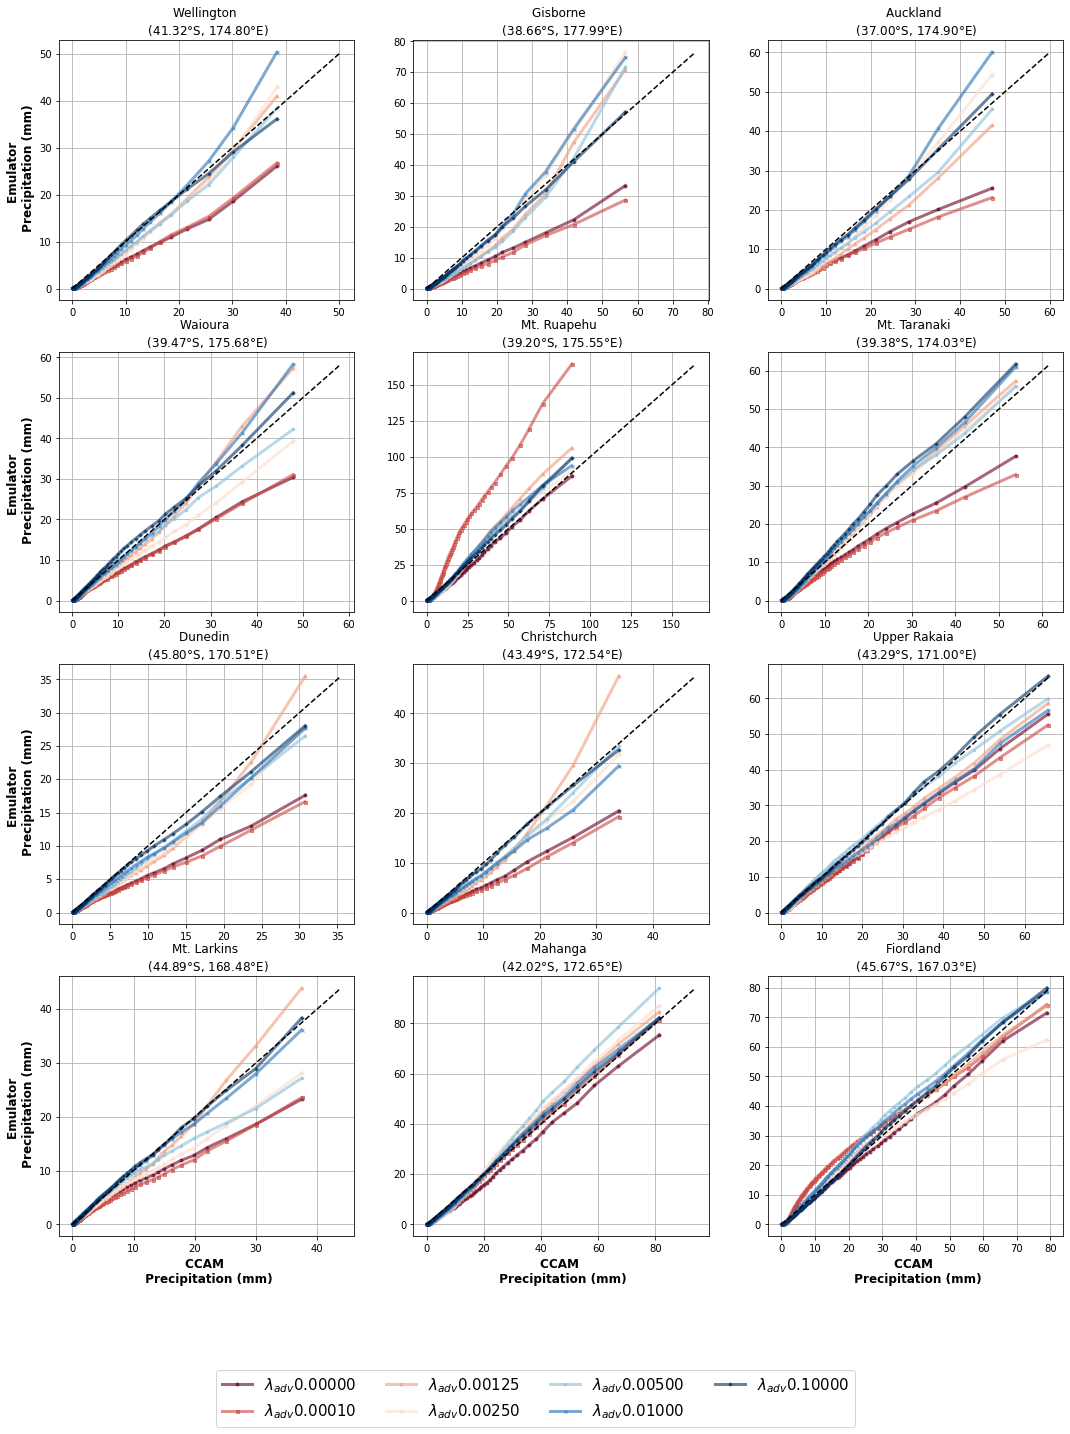

: 

In [48]:
import numpy as np
import matplotlib.pyplot as plt

# Given locations and coordinates
locations = {
    "Wellington": (-41.322, 174.804),
    "Gisborne": (-38.6586, 177.9851),
    "Auckland": (-37.00, 174.9),
    "Waioura": (-39.472, 175.682),
    "Mt. Ruapehu": (-39.19589, 175.54504),
    "Mt. Taranaki": (-39.375, 174.025),
    "Dunedin": (-45.8, 170.5147),
    "Christchurch": (-43.493, 172.537),
    "Upper Rakaia": (-43.29206, 170.99523),
    "Mt. Larkins": (-44.88526, 168.48044),
    "Mahanga": (-42.01777, 172.64677),
    "Fiordland": (-45.675, 167.025),
}

# Your provided code for z1 and z2
#z1 = y.sel(time=dsets.time).where(y.sel(time=dsets.time) > 0.05, np.nan).quantile(q=np.arange(0, 1.01, 0.01), dim ="time")
#z2 = dset3.where(dset3 > 0.05, np.nan).quantile(q=np.arange(0, 1.01, 0.01), dim ="time")

# Create a 4x3 subplot grid
fig, axs = plt.subplots(4, 3, figsize=(18, 22))


# Flatten the subplot array for easy indexing
axs = axs.flatten()

# Iterate through locations and plot q-q plots
for i, (location, coordinates) in enumerate(locations.items()):
    lat, lon = coordinates
    
    # Interpolate at the given location
    z1_interpolated = z1.interp(lat=lat, lon=lon)
    z2_interpolated = z2.interp(lat=lat, lon=lon)

    # Plot q-q plot
    for j, experiment in enumerate(z2_interpolated.experiment.values):
        #color_str = "#{:02x}{:02x}{:02x}".format(*color_gradient[j])
        axs[i].plot( z1_interpolated.pr.values.ravel()[:] ,z2_interpolated.sel(experiment = experiment).pr.values.ravel()[:], color = colors_hist[j],
                     label = '$\lambda_{adv}$' +"%.5f" % experiment, marker =marker_types[j], ms =3, alpha =0.6, lw =3)
    axs[i].plot([0, np.max(z2_interpolated.pr.values[:].ravel())], [0, np.max(z2_interpolated.pr.values[:].ravel())], 'k--')
    axs[i].set_title(f"{location} \n ({'%.2f' % abs(coordinates[0])}$\degree$S, {'%.2f' % abs(coordinates[1])}$\degree$E) ")
    axs[i].grid('on')
    # Set labels for the first column and last row
    if i % 3 == 0:
        axs[i].set_ylabel('Emulator \n Precipitation (mm)', weight ='bold', fontsize =12)
    if i >= 9:
        axs[i].set_xlabel('CCAM \n Precipitation (mm)', weight ='bold', fontsize =12)
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4, fontsize =15)
fig.savefig(f'/nesi/project/niwa00018/ML_downscaling_CCAM/training_GAN/figures/overall_results/{experiment}_{model}_qqplot_IP.png', dpi =500, bbox_inches ='tight')
# Adjust layout and show the plot
#plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#fig.suptitle('Q-Q Plots for Different Locations', y=0.94)
plt.show()



In [283]:
cmap(1000)

(0.8, 1.0, 0.6, 1.0)

In [267]:
orog.max()

<xarray.DataArray 'orog' ()>
array(1.)

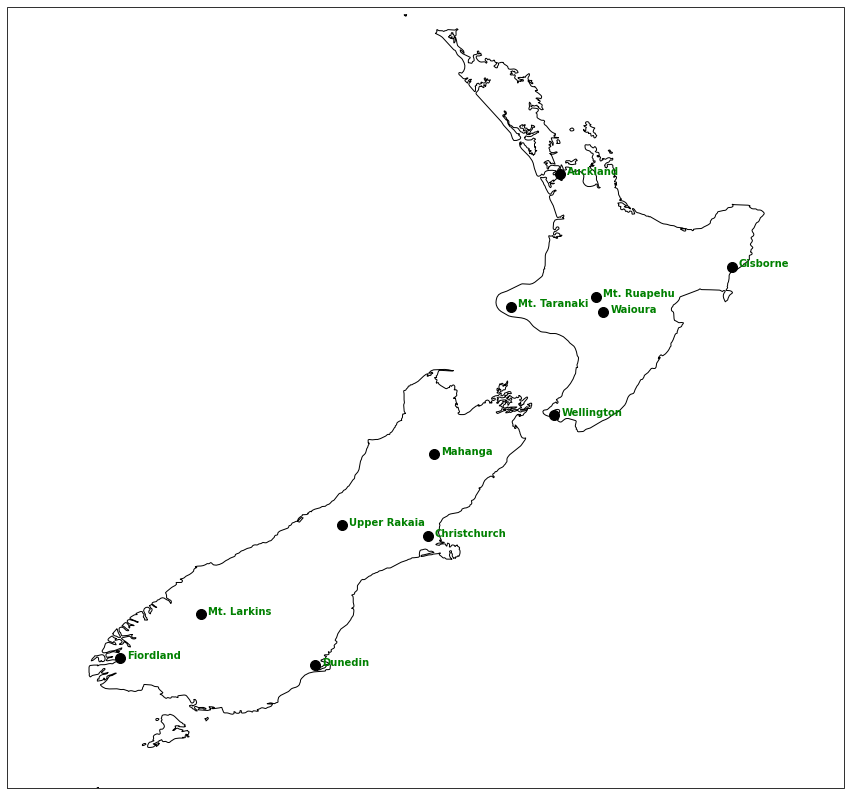

In [268]:
fig, ax = plt.subplots(subplot_kw=dict(projection = ccrs.PlateCarree(central_longitude=171.77)), figsize =(15,15))
for i, (location, coordinates) in enumerate(locations.items()):
    lat, lon = coordinates
    ax.plot(lon,lat, transform = ccrs.PlateCarree(), marker ='o', color ='k', ms=10)
    ax.text(lon+0.125,lat, location, transform = ccrs.PlateCarree(), fontsize =10, color ='k', weight ='bold')
    ax.set_extent([165, 180, -48, -34])
ax.coastlines('10m')
fig.savefig('/nesi/project/niwa00018/ML_downscaling_CCAM/training_GAN/figures/overall_figures/nz_locations.png', dpi =500, bbox_inches ='tight')

In [452]:
concat_dsets_cat

<xarray.Dataset>
Dimensions:     (experiment: 8, lon: 179, lat: 172, time: 1825, member: 10)
Coordinates:
  * experiment  (experiment) object 0.0 1e-05 0.0001 ... 0.01 0.1 'Ground Truth'
  * lon         (lon) float32 164.9 165.0 165.1 165.2 ... 183.7 183.9 184.0
  * lat         (lat) float32 -51.21 -51.11 -51.0 ... -33.07 -32.97 -32.86
  * time        (time) datetime64[ns] 1959-01-01 1959-01-02 ... 1963-12-31
Dimensions without coordinates: member
Data variables:
    pr          (experiment, member, time, lat, lon) float64 1.378 ... 0.369
Attributes: (12/19)
    source:          CSIRO conformal-cubic model. Input file: surf.ccam_12km....
    Conventions:     CF-1.7
    title:           CCAM simulation data
    contact:         ccam@csiro.au
    project:         Undefined CCAM project
    history:         Created on 2022-10-19 16:55:55
    ...              ...
    ms:              6
    ntrac:           0
    nproc:           864
    procmode:        10
    decomp:          face
    modeling_realm:  atmos